In [1]:
!pip install geopandas
!pip install earthpy
!pip install mlxtend

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import calendar
import os
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import earthpy as et
from tqdm.notebook import tqdm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.evaluate import PredefinedHoldoutSplit
import json
import copy
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [3]:
!wget --directory-prefix=../data/covid/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/covid/covid_month.csv
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data.csv
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data_only_percents.csv
!wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
!unzip -nq la_shape -d shape

# LA County Shapefile

In [4]:
# la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_filtered = la_shapes.rename(columns={'name':'region'})
la_filtered["plot_col"] = 0 # Column used to graph neighbors
la_filtered = la_filtered[['region','geometry','plot_col']]
la_filtered.head()

region                                           geometry  plot_col
0            Acton  POLYGON ((-118.20262 34.53899, -118.18947 34.5...         0
1  Adams-Normandie  POLYGON ((-118.30901 34.03741, -118.30041 34.0...         0
2     Agoura Hills  POLYGON ((-118.76193 34.16820, -118.72632 34.1...         0
3       Agua Dulce  POLYGON ((-118.25468 34.55830, -118.25551 34.5...         0
4         Alhambra  POLYGON ((-118.12175 34.10504, -118.11687 34.1...         0

## Smooth/process COVID data

In [5]:
!wget --directory-prefix=../data/covid -Nq https://raw.githubusercontent.com/ANRGUSC/lacounty_covid19_data/master/data/Covid-19.csv
covid_filename = '../data/covid/Covid-19.csv'

covid_df = pd.read_csv(covid_filename)
covid_df = covid_df.rename(columns={'Region':'region', 'Number of cases':'cases'})
covid_df.head()

Time Stamp         region   Latitude   Longitude  cases
0  03-16-2020       Alhambra  34.093042 -118.127060      2
1  03-16-2020        Arcadia  34.136208 -118.040150      1
2  03-16-2020  Beverly Hills  34.069650 -118.396306      1
3  03-16-2020  Boyle Heights  34.043689 -118.209768      5
4  03-16-2020         Carson  33.832204 -118.251755      1

In [6]:
# Set COVID cases to not be less than previously recorded - it should be a non-decreasing function
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    if prev_cases > row['cases']:
      covid_df.loc[idx, 'cases'] =  prev_cases
    else:
      prev_cases = row['cases']

In [7]:
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    covid_df.loc[idx, 'active_cases'] =  row['cases'] - prev_cases
    prev_cases = row['cases']
covid_df[covid_df['region'] == 'Alhambra']

Time Stamp    region   Latitude  Longitude  cases  active_cases
0      03-16-2020  Alhambra  34.093042 -118.12706      2           2.0
31     03-17-2020  Alhambra  34.093042 -118.12706      2           0.0
73     03-18-2020  Alhambra  34.093042 -118.12706      2           0.0
118    03-19-2020  Alhambra  34.093042 -118.12706      2           0.0
188    03-20-2020  Alhambra  34.093042 -118.12706      3           1.0
...           ...       ...        ...        ...    ...           ...
56705   11-5-2020  Alhambra  34.093042 -118.12706   1656           0.0
56943   11-6-2020  Alhambra  34.093042 -118.12706   1656           0.0
57181   11-7-2020  Alhambra  34.093042 -118.12706   1656           0.0
57419   11-8-2020  Alhambra  34.093042 -118.12706   1656           0.0
57657   11-9-2020  Alhambra  34.093042 -118.12706   1656           0.0

[233 rows x 6 columns]

## Fix inconsistencies in region name mapping

In [8]:
la_to_covid = {
    'Downtown': ['City', 'Pico', 'Wholesale District', 'Central', 'Little Tokyo', 'Temple-Beaudry'],
    'Silver Lake': ['Silverlake'],
    'Vernon': ['West Vernon', 'Vernon Central'],
    'Baldwin Hills/Crenshaw': ['Baldwin Hills'],
    'West Hollywood': ['Park LaBrea'],
    'Mid-Wilshire': ['Park LaBrea', 'Cloverdale/Cochran'],
    'Santa Clarity': ['Canyon Country'],
    'Echo Park': ['Angelino Heights'],
    'Avocado Heights': ['Bassett'],
    'Bel-Air': ['Bel Air'],
    'Arlington Heights': ['Country Club Park'],
    'Exposition Park': ['Exposition'],
    'Chinatown': ['Figueroa Park Square'],
    'Torrance': ['Gramercy Place'],
    'Harbor City': ['Harbor Pines'],
    'Mid-City': ['Lafayette Square', 'Mid-city', 'Reynier Village', 'Victoria Park', 'Wellington Square'],
    'Azusa': ['Lakeview Terrace'],
    'East Hollywood': ['Little Armenia'],
    'Playa Vista': ['Longwood'],
    'Brentwood': ['Mandeville Canyon'],
    'Playa del Rey': ['Playa Del Rey'],
    'Porter Ranch': ['Reseda Ranch'],
    'Carthay': ['South Carthay'],
    'Los Feliz': ['Thai Town'],
    'Toluca Lake': ['Toluca Terrace'],
    'El Sereno': ['University Hills'],
    'Angeles Crest': ['Angeles National Forest'],
    'Mount Washington': ['Mt. Washington']
}

for key, value in la_to_covid.items():
    covid_df.loc[covid_df['region'].isin(value), 'region'] = key

## Month aggregate

In [9]:
covid_df_month = covid_df[['Time Stamp', 'region', 'active_cases']]
covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_month = covid_df_month.set_index('Time Stamp')
covid_df_month = covid_df_month.groupby([pd.Grouper(freq='M'), 'region']).sum()
covid_df_month = covid_df_month.reset_index(level=['Time Stamp','region']).rename(columns={'Time Stamp': 'month'})
covid_df_month.month = covid_df_month.month.dt.month
covid_df_month = covid_df_month[covid_df_month.month != 3] ## Remove march data since its not complete
covid_df_month

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


month           region  active_cases
219       4            Acton          24.0
220       4  Adams-Normandie          21.0
221       4     Agoura Hills          13.0
222       4         Alhambra          31.0
223       4           Alsace          29.0
...     ...              ...           ...
1940     11      Willowbrook           0.0
1941     11       Wilmington         241.0
1942     11  Wilshire Center         180.0
1943     11         Winnetka         305.0
1944     11   Woodland Hills         234.0

[1726 rows x 3 columns]

## Census data

In [10]:
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data_only_raw.csv
census_data = pd.read_csv('../data/social_explorer_processed_data_only_raw.csv')
census_data.shape

(261, 210)

## Migration data

In [11]:
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/safegraph_aggregated.csv

migration_data = pd.read_csv('../data/safegraph_aggregated.csv')
migration_data = migration_data[['name','month','Number of incoming visits', 'Number of outgoing visits (no regI to regI)']]
migration_data = migration_data.rename(columns={'name':'region','Number of incoming visits':'incoming','Number of outgoing visits (no regI to regI)':'outgoing'})
migration_data.head(5)

region  month  incoming  outgoing
0            Agoura Hills      3        21         0
1                  Arleta      3       396     16377
2       Arlington Heights      3        80         0
3         Atwater Village      3     18134      1334
4  Baldwin Hills/Crenshaw      3       316         0

## Employment data

In [12]:
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/lodes_processed_data.csv
employment_data = pd.read_csv('../data/lodes_processed_data.csv')
employment_data = employment_data[['name', 'C000', 'CNS16', 'CNS18']].rename(columns={'name':'region','C000':'total','CNS16':'health','CNS18':'food'})
employment_data.head(5)

region  total  health  food
0            Acton   4021     479   315
1  Adams-Normandie   6100    1017   812
2     Agoura Hills   9539    1058   799
3       Agua Dulce   2158     242   144
4         Alhambra  38542    7022  4191

## Nursing Home data

In [13]:
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/Nursing_Homes_Processed_Data.csv
nursing_data = pd.read_csv('../data/Nursing_Homes_Processed_Data.csv')
nursing_data = nursing_data.rename(columns={'Neighborhood':'region','% of NursingHomeBeds':'% beds'})
nursing_data.head(5)

region  NursingHomeBeds    % beds
0            Acton                0  0.000000
1  Adams-Normandie               90  0.117246
2     Agoura Hills              185  0.241005
3       Agua Dulce                0  0.000000
4         Alhambra             1105  1.439514

In [14]:
# check_df = migration_unique_regions.assign(InDf2=migration_unique_regions.region.isin(regions.region))
# miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
# miss_arr

In [15]:
# check_df = regions.assign(InDf2=regions.region.isin(migration_unique_regions.region))
# miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
# miss_arr

In [16]:
used_features = [
  'name',
  'Area Total: Area (Land)',
  'Area Total: Area (Water)',
  'Total Population: Under 5 Years',
  'Total Population: 5 to 9 Years',
  'Total Population: 10 to 14 Years',
  'Total Population: 15 to 17 Years',
  'Total Population: 18 to 24 Years',
  'Total Population: 25 to 34 Years',
  'Total Population: 35 to 44 Years',
  'Total Population: 45 to 54 Years',
  'Total Population: 55 to 64 Years',
  'Total Population: 65 to 74 Years',
  'Total Population: 75 to 84 Years',
  'Total Population: 85 Years and Over',
  'Households: Family Households',
  'Households: Family Households: Married-Couple Family',
  'Households: Family Households: Other Family',
  'Households: Family Households: Other Family: Male Householder, No Wife Present',
  'Households: Family Households: Other Family: Female Householder, No Husband Present',
  'Households: Nonfamily Households',
  'Households: Nonfamily Households: Male Householder',
  'Households: Nonfamily Households: Female Householder',
  'Population 16 Years and Over: in Labor Force',
  'Population 16 Years and Over: in Labor Force: in Armed Forces',
  'Population 16 Years and Over: in Labor Force: Civilian',
  'Population 16 Years and Over: in Labor Force: Civilian: Employed',
  'Population 16 Years and Over: in Labor Force: Civilian: Unemployed',
  'Population 16 Years and Over: Not in Labor Force',
  'In Labor Force 16 Years and Over: in Armed Forces',
  'In Labor Force 16 Years and Over: Civilian',
  'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining',
  'Employed Civilian Population 16 Years and Over: Construction',
  'Employed Civilian Population 16 Years and Over: Manufacturing',
  'Employed Civilian Population 16 Years and Over: Wholesale Trade',
  'Employed Civilian Population 16 Years and Over: Retail Trade',
  'Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities',
  'Employed Civilian Population 16 Years and Over: Information',
  'Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing',
  'Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services',
  'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance',
  'Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services',
  'Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration',
  'Employed Civilian Population 16 Years and Over: Public Administration',
  'Employed Civilian Population 16 Years and Over1: Private Sector',
  'Employed Civilian Population 16 Years and Over1: Public Sector',
  'Employed Civilian Population 16 Years and Over1: Self-Employed (Incorporated and Not Incorporated)',
  'Employed Civilian Population 16 Years and Over1: Private Non-Profit',
  'Employed Civilian Population 16 Years and Over1: Unpaid Family Workers',
  'Households1: with Earnings', 'Households1: No Earnings',
  'Households2: with Wage or Salary Income',
  'Households2: No Wage or Salary Income',
  'Households3: with Self-Employment Income',
  'Households3: No Self-Employment Income',
  'Households4: with Interest, Dividends, or Net Rental Income',
  'Households4: No Interest, Dividends, or Net Rental Income',
  'Households5: with Social Security Income',
  'Households5: No Social Security Income',
  'Households6: with Supplemental Security Income (Ssi)',
  'Households6: No Supplemental Security Income (Ssi)',
  'Households7: with Public Assistance Income',
  'Households7: No Public Assistance Income',
  'Households8: with Retirement Income',
  'Households8: No Retirement Income',
  'Households9: with Other Types of Income',
  'Households9: No Other Types of Income',
  'Families: Income Below Poverty Level',
  'Families: Income Below Poverty Level: Married Couple Family: with Related Child Living  Bellow Poverty Level',
  'Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years',
  'Families: Income Below Poverty Level: Male Householder, No Wife Present',
  'Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years',
  'Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years',
  'Families: Income Below Poverty Level: Female Householder, No Husband Present',
  'Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years',
  'Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years',
  'Families: Income At or Above Poverty Level',
  'Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty',
  'Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level',
  'Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty',
  'Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level',
  'Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty',
  'Population Age 65 and Over for Whom Poverty  Status Is Determined: At or Above Poverty Level',
  'Population for Whom Poverty Status Is Determined: Under .50',
  'Population for Whom Poverty Status Is Determined: .50 to .74',
  'Population for Whom Poverty Status Is Determined: .75 to .99',
  'Population for Whom Poverty Status Is Determined: 1.00 to 1.49',
  'Population for Whom Poverty Status Is Determined: 1.50 to 1.99',
  'Population for Whom Poverty Status Is Determined: 2.00 and Over',
  'Population for Whom Poverty Status Is Determined1: Under 1.00 (Doing Poorly)',
  'Population for Whom Poverty Status Is Determined1: 1.00 to 1.99 (Struggling)',
  'Population for Whom Poverty Status Is Determined1: Under 2.00 (Poor or Struggling)',
  'Population for Whom Poverty Status Is Determined1: 2.00 and Over (Doing Ok)',
  'White Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
  'White Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level',
  'Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
  'Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level',
  'American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income Below Poverty Level',
  'American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income At or Above Poverty Level',
  'Asian Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
  'Asian Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level',
  'Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income Below Poverty Level',
  'Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level',
  'Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  'Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  'Two or More Races Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  'Two or More Races Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  'Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  'Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  'White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
  'White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level',
  'Workers 16 Years and Over: Car, Truck, or Van',
  'Workers 16 Years and Over: Drove Alone',
  'Workers 16 Years and Over: Carpooled',
  'Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
  'Workers 16 Years and Over: Motorcycle',
  'Workers 16 Years and Over: Bicycle',
  'Workers 16 Years and Over: Walked',
  'Workers 16 Years and Over: Other Means',
  'Workers 16 Years and Over: Worked At Home',
  'Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units',
  'Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Car, Truck, or Van - Drove Alone',
  'Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Car, Truck, or Van - Carpooled',
  'Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Public Transportation (Excluding Taxicab)',
  'Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Walked',
  'Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Taxicab, Motorcycle, Bicycle, or Other Means',
  'Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Worked At Home',
  'Workers 16 Years and Over2: Did Not Work At Home',
  'Workers 16 Years and Over2: Did Not Work At Home: Less than 10 Minutes',
  'Workers 16 Years and Over2: Did Not Work At Home: 10 to 19 Minutes',
  'Workers 16 Years and Over2: Did Not Work At Home: 20 to 29 Minutes',
  'Workers 16 Years and Over2: Did Not Work At Home: 30 to 39 Minutes',
  'Workers 16 Years and Over2: Did Not Work At Home: 40 to 59 Minutes',
  'Workers 16 Years and Over2: Did Not Work At Home: 60 to 89 Minutes',
  'Workers 16 Years and Over2: Did Not Work At Home: 90 or More Minutes',
  'Workers 16 Years and Over2: Worked At Home',
  'Total: No Health Insurance Coverage',
  'Total: with Health Insurance Coverage',
  'Total: with Health Insurance Coverage: Public Health Coverage',
  'Total: with Health Insurance Coverage: Private Health Insurance',
  'Population Under 18: No Health Insurance Coverage',
  'Population Under 18: with Health Insurance Coverage',
  'Population Under 18: with Health Insurance Coverage: Public Health Coverage',
  'Population Under 18: with Health Insurance Coverage: Private Health Insurance',
  'Population 18 to 24: No Health Insurance Coverage',
  'Population 18 to 24: with Health Insurance Coverage',
  'Population 18 to 24: with Health Insurance Coverage: Public Health Coverage',
  'Population 18 to 24: with Health Insurance Coverage: Private Health Insurance',
  'Population 25 to 34: No Health Insurance Coverage',
  'Population 25 to 34: with Health Insurance Coverage',
  'Population 25 to 34: with Health Insurance Coverage: Public Health Coverage',
  'Population 25 to 34: with Health Insurance Coverage: Private Health Insurance',
  'Population 35 to 64: No Health Insurance Coverage',
  'Population 35 to 64: with Health Insurance Coverage',
  'Population 35 to 64: with Health Insurance Coverage: Public Health Coverage',
  'Population 35 to 64: with Health Insurance Coverage: Private Health Insurance',
  'Population 65 or Older: No Health Insurance Coverage',
  'Population 65 or Older: with Health Insurance Coverage',
  'Population 65 or Older: with Health Insurance Coverage: Public Health Coverage',
  'Population 65 or Older: with Health Insurance Coverage: Private Health Insurance',
  'Own Children under 18 Years: Children Living with Single Parents',
  'Households10: 1-Person Household',
  'Households10: 2-Person Household',
  'Households10: 3-Person Household',
  'Households10: 4-Person Household',
  'Households10: 5-Person Household',
  'Households10: 6-Person Household',
  'Households10: 7-or-More Person Household'
]

for feature in census_data.columns:
    if feature not in used_features:
        del census_data[feature]
        print("Deleted ", feature)

census_data.head()
feature_names = np.concatenate((['cases', 'County total cases', 'Incoming migration','Outgoing migration','Nursing home density', 'Total jobs', 'Healthcare workers', 'Food Services workers'], census_data.columns.values[1:]))
feature_names

Deleted  Area Total:
Deleted  Total Population:
Deleted  Households:
Deleted  Population 16 Years and Over:
Deleted  In Labor Force 16 Years and Over:
Deleted  Employed Civilian Population 16 Years and Over:
Deleted  Employed Civilian Population 16 Years and Over1:
Deleted  Households1:
Deleted  Households2:
Deleted  Households3:
Deleted  Households4:
Deleted  Households5:
Deleted  Households6:
Deleted  Households7:
Deleted  Households8:
Deleted  Households9:
Deleted  Families:
Deleted  Population Under 18 Years of Age for Whom Poverty Status Is Determined:
Deleted  Population Age 18 to 64 for Whom Poverty Status  Is Determined:
Deleted  Population Age 65 and Over for Whom Poverty  Status Is Determined:
Deleted  Population for Whom Poverty Status Is Determined:
Deleted  Population for Whom Poverty Status Is Determined1:
Deleted  White Alone Population for Whom Poverty Status Is  Determined:
Deleted  Black or African American Alone Population for  Whom Poverty Status Is Determined:
Dele

array(['cases', 'County total cases', 'Incoming migration',
       'Outgoing migration', 'Nursing home density', 'Total jobs',
       'Healthcare workers', 'Food Services workers',
       'Area Total: Area (Land)', 'Area Total: Area (Water)',
       'Total Population: Under 5 Years',
       'Total Population: 5 to 9 Years',
       'Total Population: 10 to 14 Years',
       'Total Population: 15 to 17 Years',
       'Total Population: 18 to 24 Years',
       'Total Population: 25 to 34 Years',
       'Total Population: 35 to 44 Years',
       'Total Population: 45 to 54 Years',
       'Total Population: 55 to 64 Years',
       'Total Population: 65 to 74 Years',
       'Total Population: 75 to 84 Years',
       'Total Population: 85 Years and Over',
       'Households: Family Households',
       'Households: Family Households: Married-Couple Family',
       'Households: Family Households: Other Family',
       'Households: Family Households: Other Family: Male Householder, No Wife Prese

In [17]:
# Graph neighbors of a region
def graph_neighbors(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)
    temp_n = df[df.region == region].neighbors.values[0].split(',')
    temp_n = [n.strip() for n in temp_n]
    for n in temp_n:
        df.plot_col = df.plot_col.mask(df['region'] == n, 2)
    ax = df.plot(column='plot_col', figsize=(10,10))
    green_patch = mpatches.Patch(color='green', label='Covering Polygon')
    yellow_patch = mpatches.Patch(color='yellow', label='Bordering Regions')
    purple_patch = mpatches.Patch(color='purple', label='Inner LA County')
    plt.legend(handles=[green_patch, yellow_patch, purple_patch])
#     ax.annotate()
#     df2.apply(lambda x: ax.annotate(s=x.region, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    
# Graph region
def graph_region(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)

    df.plot(column='plot_col', figsize=(10,10), alpha=0.5)
    
def get_neighbors(df, graph=False):
    df2 = df.copy(deep=True)
    df2["neighbors"] = None  # add NEIGHBORS column
    df2["plot_col"] = 0 # Column used to graph neighbors
    # Create a polygon that covers the entire la county region
    cover = gpd.GeoSeries(Polygon([(-119.4,35), (-119.4,33.2), (-117,33.2), (-117,35)])).set_crs(epsg=4269)
    # Remove Catalina Island since it is an island which has no neighbors
    la_noisland = df2[df2['region']!='Unincorporated Catalina Island']
    # Remove small holes within the la county unary union polygon
    no_holes = MultiPolygon(Polygon(p.exterior) for p in la_noisland.geometry.unary_union)
    no_holes_series = gpd.GeoSeries(no_holes).set_crs(epsg=4269)
    # Subtract la county from the covering polygon
    diff = gpd.GeoSeries.difference(cover, no_holes_series)
    # We can find the cities that are touching 'diff' to locate border cities
    # diff.plot(figsize=(5,5))
    # Get neighbors of diff to obtain bordered regions
    border_regions = df2[~df2.geometry.disjoint(diff[0])].region.tolist()
    ## Graph border regions
    if graph:
        df2.loc[len(df2)] = ["COVER", diff[0], 0, ", ".join(border_regions)]
        graph_neighbors(df2, 'COVER')
        df2 = df2[:-1]
    ## Find neighbors of each region
    for index, row in df2.iterrows():   
        # Get neighboring cities
        neighbors = df2[~df2.geometry.disjoint(row.geometry)].region.tolist()
        # Remove own name from list
        if row['region'] in neighbors:
            neighbors.remove(row['region'])
        df2.at[index, "neighbors"] = ", ".join(neighbors)
        
    if graph:
        graph_neighbors(df2, 'Winnetka')
    df2 = df2[['region','neighbors','geometry']]
    
    ## Remove Borders
    df_inner = df2[~df2['region'].isin(border_regions)]
    
    covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
    check_df = df_inner.assign(InDf2=df_inner.region.isin(covid_unique_regions.region))
    miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
    miss_set = set(miss_arr)
    for region in miss_arr:
        temp_n = df_inner[df_inner.region == region].neighbors.values[0].split(',')
        temp_n = set([n.strip() for n in temp_n])
        miss_set = miss_set | temp_n
    miss_arr = list(miss_set)
    df_inner = df_inner[~df_inner['region'].isin(miss_arr)]
    return df_inner

In [18]:
def build_month_data(neighbors=False, migration=False, static=False):
    # Get all regions that have data
    covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
    nursing_unique_regions = pd.DataFrame(data=pd.unique(nursing_data.region),columns=['region']) if static else None
    employment_unique_regions = pd.DataFrame(data=pd.unique(employment_data.region),columns=['region']) if static else None
    migration_unique_regions = pd.DataFrame(data=pd.unique(migration_data.region),columns=['region']) if migration else None
    census_unique_regions = pd.DataFrame(data=pd.unique(census_data.name),columns=['region']) if static else None
    la_neighbors = get_neighbors(la_filtered) if neighbors else None
    regions = pd.merge(covid_unique_regions, la_filtered, on='region', how='inner')
    if neighbors:
        regions = pd.merge(regions, la_neighbors, on='region', how='inner')
    if migration:
        regions = pd.merge(regions, migration_unique_regions, on='region', how='inner')
    if static:
        regions = pd.merge(regions, census_unique_regions, on='region', how='inner')
        regions = pd.merge(regions, nursing_unique_regions, on='region', how='inner')
        regions = pd.merge(regions, employment_unique_regions, on='region', how='inner')
    regions = regions['region'].values
    print(len(regions))
    
    month_data = np.array([])
    # List of months
    time_frames = pd.unique(covid_df_month.month)
    # List of month case sums
    covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

    for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
        time_frame = time_frames[i]
        for region in regions:
            # Build current row of data
            row_data = np.array([time_frame])
            # Get cases for current region
            region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['active_cases'].values
            if len(region_cases) == 0:
                region_cases = 0
            else:
                region_cases = region_cases[0]
            row_data = np.append(row_data, [region_cases])

            # Get cases of the entire LA region
            total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['active_cases'].values[0]
            row_data = np.append(row_data, [total_cases])
            
            # Get neighbors cases
            if neighbors:
                neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
                neighbors = neighbors.split(',')
                neighbors = [neighbor.strip() for neighbor in neighbors]
                total_neighbors_cases = 0
                for neighbor in neighbors:
                    neighbor_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == neighbor)]['active_cases'].values
                    if len(neighbor_cases) != 0:
                        total_neighbors_cases += neighbor_cases[0]
                row_data = np.append(row_data, [total_neighbors_cases])
            
            # migration
            if migration:
                # Incoming
                in_mig = migration_data[(migration_data['month'] == time_frame) & (migration_data['region'] == region)]['incoming'].values
                if len(in_mig) == 0:
                    in_mig = 0
                else:
                    in_mig = in_mig[0]
                row_data = np.append(row_data, [in_mig])

                # Outgoing
                out_mig = migration_data[(migration_data['month'] == time_frame) & (migration_data['region'] == region)]['outgoing'].values
                if len(out_mig) == 0:
                    out_mig = 0
                else:
                    out_mig = out_mig[0]
                row_data = np.append(row_data, [out_mig])
            
            # Static data
            if static:
                nurse_den = nursing_data[nursing_data['region'] == region]['% beds'].values
                if len(nurse_den) == 0:
                    nurse_den = 0
                else:
                    nurse_den = nurse_den[0]
                row_data = np.append(row_data, [nurse_den])

                # Total jobs
                emp_data = employment_data[employment_data['region'] == region].values[0]
                row_data = np.append(row_data, [emp_data[1], emp_data[2], emp_data[3]])

                # Get census data
                census_row = census_data[census_data['name']==region].values[0][1:]/100
                row_data = np.append(row_data, census_row)

            # Get cases for next time_frame
            next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['active_cases'].values
            # This data is not available yet
            if len(next_cases) == 0:
                next_cases = 0
            else:
                next_cases = next_cases[0]
            row_data = np.append(row_data, [next_cases])

            # Add data to numpy arr
            if len(month_data.shape) == 1:
                month_data = np.array([row_data])
            else:
                month_data = np.append(month_data, [row_data], axis=0)
                month_data = month_data.astype(float)
                month_data[:,~np.isnan(month_data).any(axis=0)].shape
    return month_data, regions

# Model Training

### Data Transformation

In [19]:
def transform_data(data):
    pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
#     pipe = make_pipeline(StandardScaler())
    if len(data.shape) == 1:
        transformed_data = pipe.fit_transform(data.reshape(-1,1))
        return (transformed_data.reshape(-1,), pipe)
    transformed_data = pipe.fit_transform(data)
    return (transformed_data, pipe)
def apply_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.transform(data.reshape(-1,1)).reshape(-1,)
    return pipe.transform(data)
def inverse_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.inverse_transform(data.reshape(-1,1)).reshape(-1,)
    return pipe.inverse_transform(data)

### Time validation

In [20]:
def n_month_window_split(data, n, transform = True):
    X_train_arr = []
    X_test_arr = []
    y_train_arr = []
    y_test_arr = []
    ptX_arr = []
    pty_arr = []
    for i in range(int(data[0,0]), int(data[-1,0]-n+1)):
        train_start_index = np.where(data[:,0]==i)[0][0]
        train_end_index = np.where(data[:,0]==i+n)[0][0]
        test_start_index = train_end_index
        test_end_index = np.where(data[:,0]==i+n)[0][-1]+1
        X_train = data[train_start_index:train_end_index, 1:-1]
        X_test = data[test_start_index:test_end_index, 1:-1]
        y_train = data[train_start_index:train_end_index, -1]
        y_test = data[test_start_index:test_end_index, -1]

        
#         print('============')
#         print(train_start_index, test_start_index, test_end_index)
#         print('============')
        
        # Feature transformation
        ## Transformation should be done on the training set and applied on testing set
        if transform:
            X_train, pt_X = transform_data(X_train)
            X_test = apply_transform(pt_X, X_test)
            y_train, pt_y = transform_data(y_train)
            y_test = apply_transform(pt_y, y_test)
            ptX_arr.append(pt_X)
            pty_arr.append(pt_y)
        
        X_train_arr.append(X_train)
        X_test_arr.append(X_test)
        y_train_arr.append(y_train)
        y_test_arr.append(y_test)
        
    return (X_train_arr, X_test_arr, y_train_arr, y_test_arr, ptX_arr, pty_arr)

### Feature selection

In [21]:
def f_selection(model, kfeatures, X_train, X_test, y_train, y_test, floating=False):
    fs_X = np.vstack((X_train,X_test))
    fs_y = np.hstack((y_train, y_test))
    fs_cv_in = np.array(list(range(X_train.shape[0]-1,fs_X.shape[0])))
    piter = PredefinedHoldoutSplit(fs_cv_in)

    sfs1 = sfs(model,
            k_features=kfeatures,
            forward=True,
            floating=floating,
            verbose=0,
            scoring='r2',
            cv=piter)

    # Perform SFFS
    sfs1 = sfs1.fit(fs_X, fs_y)
    return sfs1.subsets_

In [22]:
def get_fs_data(data, feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
#     optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
    optimal_index = np.array(list(optimal_feat['feature_idx']))
    names = np.array(feature_names)[optimal_index]
    print(names)
    print(optimal_r2)
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    
    temp = np.append(optimal_index+1, data.shape[1]-1)
    data2 = copy.deepcopy(data[:, np.insert(temp, 0, 0, axis=0)]) # Insert month and target columns
    return (data2, names)

In [23]:
print(la_filtered.head())

            region                                           geometry  plot_col
0            Acton  POLYGON ((-118.20262 34.53899, -118.18947 34.5...         0
1  Adams-Normandie  POLYGON ((-118.30901 34.03741, -118.30041 34.0...         0
2     Agoura Hills  POLYGON ((-118.76193 34.16820, -118.72632 34.1...         0
3       Agua Dulce  POLYGON ((-118.25468 34.55830, -118.25551 34.5...         0
4         Alhambra  POLYGON ((-118.12175 34.10504, -118.11687 34.1...         0


### Train model

In [58]:
def generate_map(predicted, actual, region_names, month='October'):
  map_data_dict = {'region': region_names, 'Predicted': predicted, 'Actual': actual}
  map_data = pd.DataFrame(map_data_dict)
  map_data['Actual'] = map_data['Actual'].astype(int)
  map_data['Error'] = (map_data['Predicted'] - map_data['Actual']).astype(int)
  df = la_filtered.merge(map_data, on='region', how='inner')
  print(df[df['Error'] > .5 * df['Actual']][['region','Predicted','Actual','Error']])
  print(df[df['Error'] < -.5 * df['Actual']][['region','Predicted','Actual','Error']])

  # plot used regions
  used = map_data[la_filtered['region'].isin(region_names)]
  colors = ['green' if region in region_names else 'blue' for region in la_filtered['region']]
  la_filtered.plot(color=colors, figsize=(8,6))

  # plot predicted cases
  f, ax = plt.subplots(1, figsize=(8,6))
  df.plot(column='Predicted', ax=ax, vmin = 0, vmax = max(df['Predicted'].max(), df['Actual'].max()), legend=True)
  f.suptitle('Predicted COVID-19 cases distribution for {m}'.format(m=month))

  # plot actual cases
  f, ax = plt.subplots(1, figsize=(8,6))
  df.plot(column='Actual', ax=ax, vmin = 0, vmax = max(df['Predicted'].max(), df['Actual'].max()), legend=True)
  f.suptitle('Actual COVID-19 cases distribution for {m}'.format(m=month))

  # plot error
  f, ax = plt.subplots(1, figsize=(8,6))
  df.plot(column='Error', ax=ax, legend=True)
  f.suptitle('Error (predicted - actual) in COVID-19 cases distribution for {m}'.format(m=month))

  plt.show()

def train_model(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title, pty_arr, n, region_names):
    inverse_y_test_arr = []
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        inverse_y_test_arr.append(inverse_transform(pty_arr[i], y_test_arr[i]))
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(inverse_transform(pty_arr[i], model.predict(X_test_arr[i])))
        mse_arr.append(mean_squared_error(y_pred_arr[i], inverse_y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], inverse_y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], inverse_y_test_arr[i]))
        avg_arr.append(np.average(inverse_y_test_arr[i]))
    print('MSE: {a}; avg = {mseA} \nr2: {b}; avg = {r2A}\nMAE: {c}; avg = {maeA}\navg: {d}; avg = {avgA}'.format(
        a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr, 
        mseA=np.array(mse_arr).mean(),
        r2A=np.array(r2_arr).mean(),
        maeA=np.array(mae_arr).mean(),
        avgA=np.array(avg_arr).mean()
    ))
    if len(avg_arr)==1:
        # Graph
        fig, ax = plt.subplots(figsize=[8,6])
        ax.scatter(inverse_y_test_arr[0], y_pred_arr[0])
        ax.plot([inverse_y_test_arr[0].min(), inverse_y_test_arr[0].max()], [inverse_y_test_arr[0].min(), inverse_y_test_arr[0].max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[i+5+n]))
        plt.show()
        generate_map(y_pred_arr[0], inverse_y_test_arr[0], region_names, calendar.month_name[i+5+n])
        return
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(inverse_y_test_arr[i], y_pred_arr[i])
        axs[i].plot([inverse_y_test_arr[i].min(), inverse_y_test_arr[i].max()], [inverse_y_test_arr[i].min(), inverse_y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for {m}'.format(m=calendar.month_name[i+5+n]))
        generate_map(y_pred_arr[i], inverse_y_test_arr[i], region_names, calendar.month_name[i+5+n])
    fig.suptitle(graph_title, fontsize=16)
    plt.show()


In [25]:
def train_model_no_transform(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title, n):
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(model.predict(X_test_arr[i]))
        mse_arr.append(mean_squared_error(y_pred_arr[i], y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], y_test_arr[i]))
        avg_arr.append(np.average(y_test_arr[i]))
    print('MSE: {a}; avg = {mseA} \nr2: {b}; avg = {r2A}\nMAE: {c}; avg = {maeA}\navg: {d}; avg = {avgA}'.format(
        a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr, 
        mseA=np.array(mse_arr).mean(),
        r2A=np.array(r2_arr).mean(),
        maeA=np.array(mae_arr).mean(),
        avgA=np.array(avg_arr).mean()
    ))

    if len(avg_arr)==1:
        # Graph
        fig, ax = plt.subplots(figsize=[8,6])
        ax.scatter(y_test_arr[0], y_pred_arr[0])
        ax.plot([y_test_arr[0].min(), y_test_arr[0].max()], [y_test_arr[0].min(), y_test_arr[0].max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[i+5+n]))
        plt.show()
        return
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(y_test_arr[i], y_pred_arr[i])
        axs[i].plot([y_test_arr[i].min(), y_test_arr[i].max()], [y_test_arr[i].min(), y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for {m}'.format(m=calendar.month_name[i+5+n]))
    fig.suptitle(graph_title, fontsize=16)
    plt.show()

In [59]:
def train_model_single(X_train, X_test, y_train, y_test, model, graph_title, month, pty, region_names):
    inverse_y_test = inverse_transform(pty, y_test)
    model.fit(X_train, y_train)
    y_pred = inverse_transform(pty, model.predict(X_test))
    mse = mean_squared_error(y_pred, inverse_y_test)
    r2 = r2_score(y_pred, inverse_y_test)
    mae = mean_absolute_error(y_pred, inverse_y_test)
    avg =  np.average(inverse_y_test)
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=avg))

    # Graph
    fig, ax = plt.subplots(figsize=[8,4])
    ax.scatter(inverse_y_test, y_pred)
    ax.plot([inverse_y_test.min(), inverse_y_test.max()], [inverse_y_test.min(), inverse_y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[month]))
    plt.show()
    generate_map(y_pred, inverse_y_test, region_names, month=calendar.month_name[month])


### Local search


In [27]:
def search_model(X_train, X_test, y_train, y_test, model, graph_title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    error = {
        'mse': mse,
        'r2': r2,
        'mae': mae
    }
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=np.average(y_test)))
    
    # Graph
    fig, ax = plt.subplots(figsize=[8,6])
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(graph_title)
    plt.show()
    print(model.best_estimator_)

### Feature Importance

In [28]:
# Feature importance graphs for SVR
def f_importances(model, names, model_name):
    if model_name == 'linear':
        ## Graph absolute value of feature importance
        w = pd.Series(abs(model.coef_))
        w,n = zip(*sorted(zip(w,names), reverse=True))
        plt.barh(n[:10][::-1], w[:10][::-1])
        # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
        # plt.yticks(range(len(names)), names)
        plt.show()
        
        w = pd.Series(model.coef_)
        df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
        return df[['Feature Name','Weight']]
    if model_name == 'SVR':
        ## Graph absolute value of feature importance
        w = pd.Series(abs(model.coef_[0]))
        w,n = zip(*sorted(zip(w,names), reverse=True))
        plt.barh(n[:10][::-1], w[:10][::-1])
        # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
        # plt.yticks(range(len(names)), names)
        plt.show()
        
        w = pd.Series(model.coef_[0])
        df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
        return df[['Feature Name','Weight']]
    
    ## Graph absolute value of feature importance
    w = pd.Series(abs(model.feature_importances_))
    w,n = zip(*sorted(zip(w,names), reverse=True))
    plt.barh(n[:10][::-1], w[:10][::-1])
    # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
    # plt.yticks(range(len(names)), names)
    plt.show()

    w = pd.Series(abs(model.feature_importances_))
    df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
    return df[['Feature Name','Weight']]

# Linear Regression

### Cases Only

In [29]:
lin_model = LinearRegression()

195
(1170, 4)
MSE: [14253.918825482062]; avg = 14253.918825482062 
r2: [-0.0029941346982536032]; avg = -0.0029941346982536032
MAE: [93.53014802395828]; avg = 93.53014802395828
avg: [160.03589743589743]; avg = 160.03589743589743


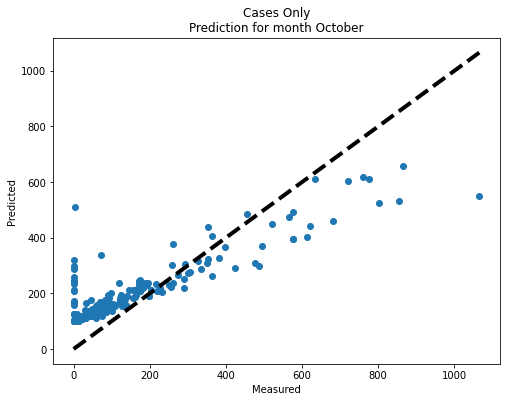

In [30]:
month_data, used_regions = build_month_data()
print(month_data.shape)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases Only", 5)

### Add Normalization

195
MSE: [9110.348274318343]; avg = 9110.348274318343 
r2: [0.6939661638243622]; avg = 0.6939661638243622
MAE: [53.67019228808268]; avg = 53.67019228808268
avg: [160.03589743589743]; avg = 160.03589743589743


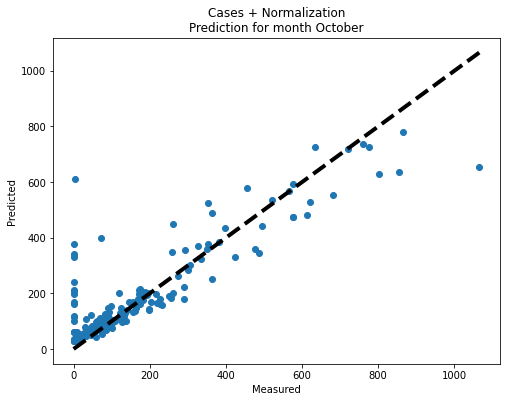

                region   Predicted  Actual  Error
0                Acton  116.082202       0    116
4             Altadena  125.254512      83     42
5        Angeles Crest   30.061797       0     30
8    Arlington Heights  122.194834      45     77
9              Artesia  108.960958      32     76
..                 ...         ...     ...    ...
170            Valinda  162.222972       0    162
175     Vermont Knolls   74.489166      45     29
176     Vermont Square   61.346423      31     30
187   Westlake Village   36.111801       7     29
191        Willowbrook  210.223563       0    210

[68 rows x 4 columns]
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


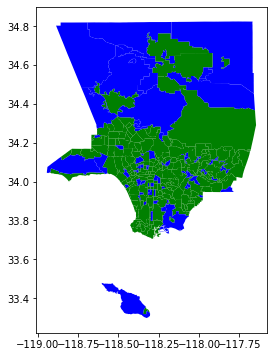

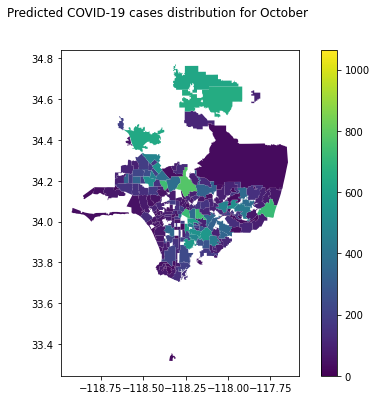

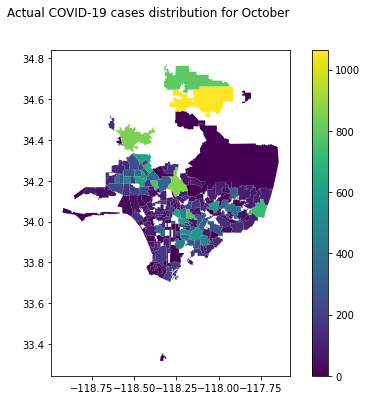

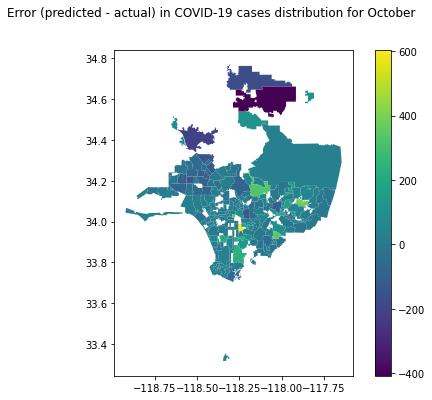

In [31]:
month_data, used_regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization", nc5m_pty_arr, 5, used_regions)

### Add Migration

91
MSE: [5517.8301606586565]; avg = 5517.8301606586565 
r2: [0.7916184716172029]; avg = 0.7916184716172029
MAE: [45.04391046366503]; avg = 45.04391046366503
avg: [191.46153846153845]; avg = 191.46153846153845


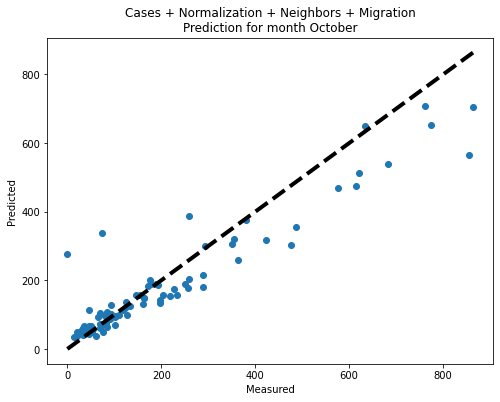

                 region   Predicted  Actual  Error
3     Arlington Heights  113.372686      44     69
6         Beverly Crest   46.724199      25     21
7         Beverly Hills  104.668900      68     36
8           Beverlywood   52.536670      28     24
22         Elysian Park   34.208733      14     20
28         Hancock Park   62.463116      32     30
38         Leimert Park   64.080994      42     22
52    Pacific Palisades   42.900582      27     15
55             Pasadena  277.243421       0    277
58  Rancho Palos Verdes   65.797372      34     31
63         Shadow Hills   38.210875      19     19
66       South Pasadena   58.314685      38     20
72          Toluca Lake   49.871076      20     29
75      University Park  339.162791      72    267
80       Vermont Knolls   67.805449      44     23
81       Vermont Square   55.405769      30     25
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


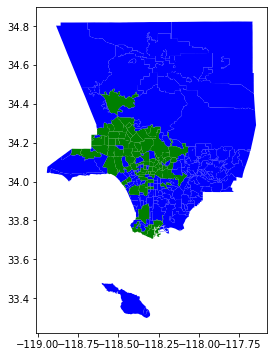

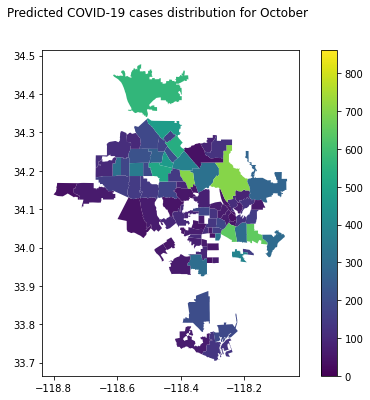

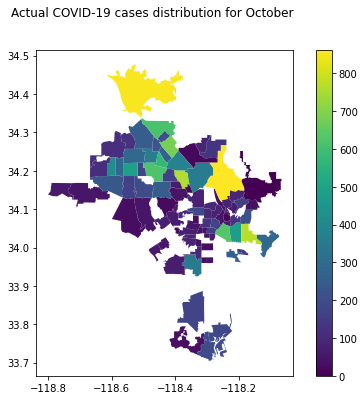

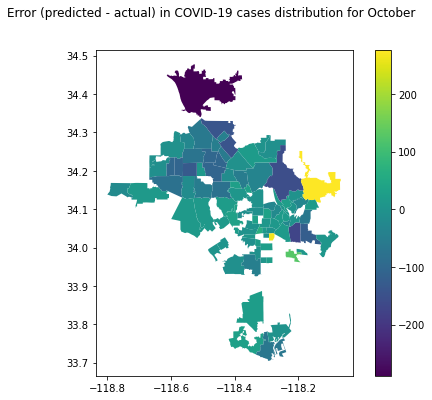

In [32]:
month_data, used_regions = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5, used_regions)

### Add Census

91
['Adams-Normandie', 'Agoura Hills', 'Arleta', 'Arlington Heights', 'Atwater Village', 'Baldwin Hills/Crenshaw', 'Beverly Crest', 'Beverly Hills', 'Beverlywood', 'Boyle Heights', 'Brentwood', 'Burbank', 'Calabasas', 'Canoga Park', 'Chatsworth', 'Chinatown', 'Downtown', 'Eagle Rock', 'East Hollywood', 'East Los Angeles', 'Echo Park', 'El Sereno', 'Elysian Park', 'Elysian Valley', 'Encino', 'Glassell Park', 'Glendale', 'Granada Hills', 'Hancock Park', 'Harvard Heights', 'Highland Park', 'Hollywood', 'Hollywood Hills', 'Huntington Park', 'Hyde Park', 'Inglewood', 'Koreatown', 'Lake Balboa', 'Leimert Park', 'Lincoln Heights', 'Los Feliz', 'Manchester Square', 'Mar Vista', 'Maywood', 'Mid-City', 'Mid-Wilshire', 'Mission Hills', 'Montebello', 'Mount Washington', 'North Hills', 'North Hollywood', 'Northridge', 'Pacific Palisades', 'Pacoima', 'Panorama City', 'Pasadena', 'Pico-Union', 'Porter Ranch', 'Rancho Palos Verdes', 'Reseda', 'San Fernando', 'San Pedro', 'Santa Clarita', 'Shadow Hills

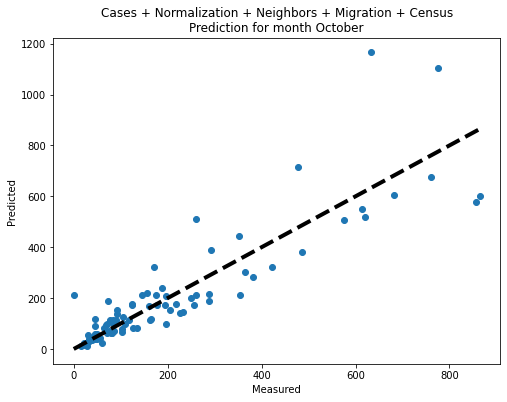

             region    Predicted  Actual  Error
16         Downtown  1165.259142     633    532
18   East Hollywood   152.265965      91     61
29  Harvard Heights    89.883321      44     45
33  Huntington Park   511.562876     260    251
44         Mid-City   115.403262      76     39
55         Pasadena   211.432700       0    211
75  University Park   188.403548      72    116
80   Vermont Knolls   118.977611      44     74
81   Vermont Square    53.127511      30     23
82       West Adams   138.888793      91     47
86         Westlake   321.371759     171    150
         region  Predicted  Actual  Error
1  Agoura Hills   21.82646      59    -37


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


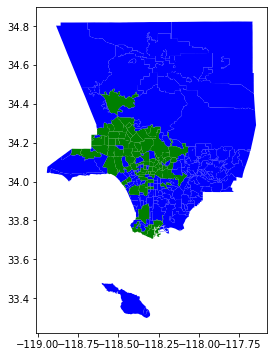

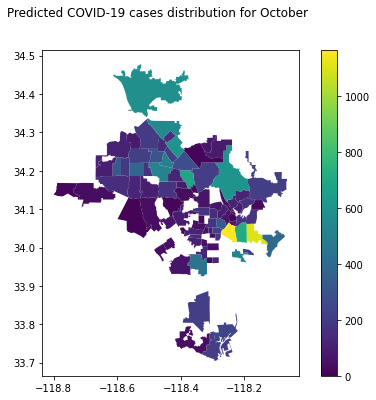

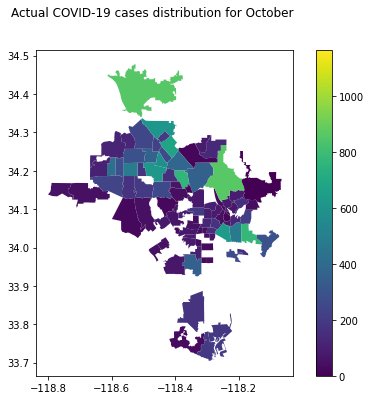

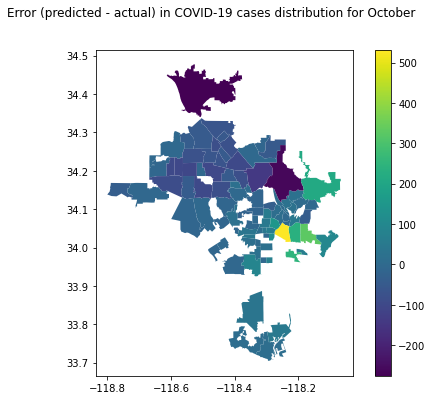

In [61]:
month_data, used_regions = build_month_data(False, True, True)
print(sorted(used_regions))
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5, used_regions)

## 5-month window

### Feature Selection

In [34]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data, 5)
# lin_feat_subsets5 = f_selection(lin_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_X_test_arr[0],wc5m_y_train_arr[0],wc5m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets5.npy', lin_feat_subsets5, allow_pickle=True)

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Nursing home density' 'Total Population: 15 to 17 Years'
 'Households: Family Households: Other Family: Female Householder, No Husband Present'
 'Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 'Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration'
 'Households4: No Interest, Dividends, or Net Rental Income'
 'Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years'
 'Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level'
 'Asian Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level'
 'Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level'
 'White Alone, Not Hispanic or Latino Population  for Who

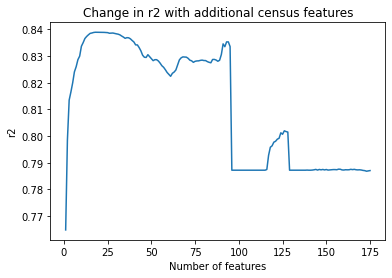

In [35]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets5.npy
lin_feat_subsets5 = np.load('../data/feat_selection/lin_feat_subsets5.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets5)

In [36]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

MSE: [5517.8301606586565]; avg = 5517.8301606586565 
r2: [0.7916184716172029]; avg = 0.7916184716172029
MAE: [45.04391046366503]; avg = 45.04391046366503
avg: [191.46153846153845]; avg = 191.46153846153845


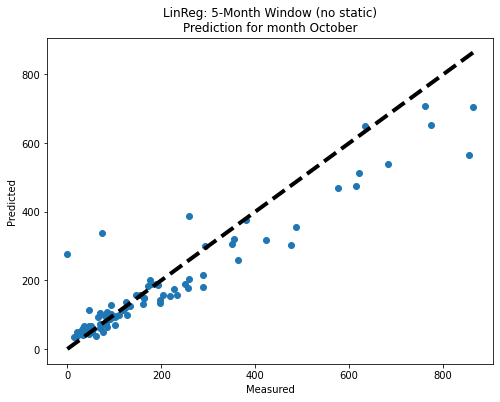

                 region   Predicted  Actual  Error
3     Arlington Heights  113.372686      44     69
6         Beverly Crest   46.724199      25     21
7         Beverly Hills  104.668900      68     36
8           Beverlywood   52.536670      28     24
22         Elysian Park   34.208733      14     20
28         Hancock Park   62.463116      32     30
38         Leimert Park   64.080994      42     22
52    Pacific Palisades   42.900582      27     15
55             Pasadena  277.243421       0    277
58  Rancho Palos Verdes   65.797372      34     31
63         Shadow Hills   38.210875      19     19
66       South Pasadena   58.314685      38     20
72          Toluca Lake   49.871076      20     29
75      University Park  339.162791      72    267
80       Vermont Knolls   67.805449      44     23
81       Vermont Square   55.405769      30     25
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


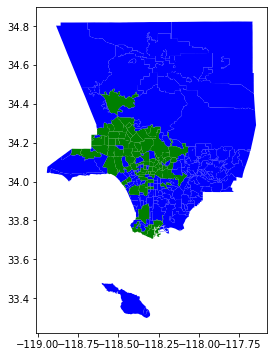

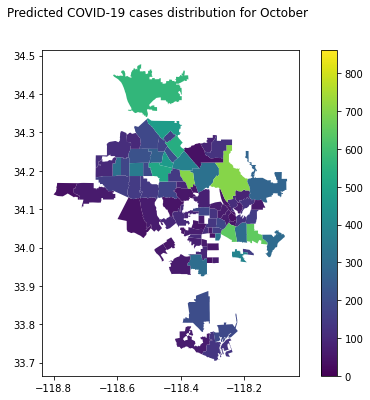

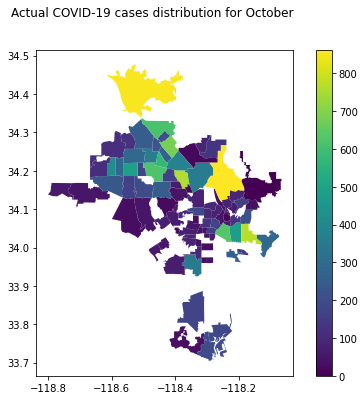

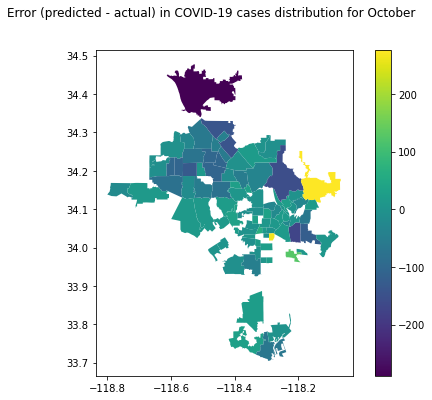

In [37]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "LinReg: 5-Month Window (no static)", nc5m_pty_arr, 5, used_regions)

MSE: [4741.060486947412]; avg = 4741.060486947412 
r2: [0.8341584402274004]; avg = 0.8341584402274004
MAE: [42.51305011881675]; avg = 42.51305011881675
avg: [191.46153846153845]; avg = 191.46153846153845


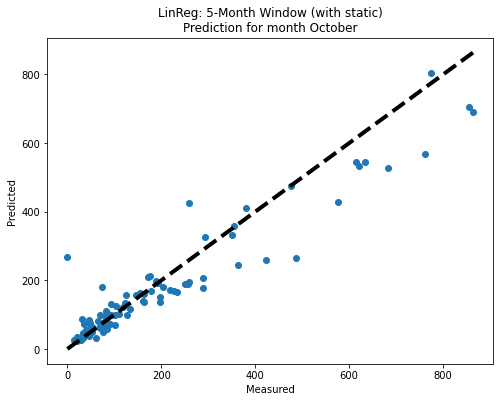

                 region   Predicted  Actual  Error
3     Arlington Heights   77.568363      44     33
20            Echo Park   76.026797      48     28
22         Elysian Park   26.968863      14     12
33      Huntington Park  425.530192     260    165
55             Pasadena  267.059063       0    267
58  Rancho Palos Verdes   73.005178      34     39
72          Toluca Lake   35.564081      20     15
75      University Park  180.795801      72    108
80       Vermont Knolls   83.633704      44     39
81       Vermont Square   87.283765      30     57
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


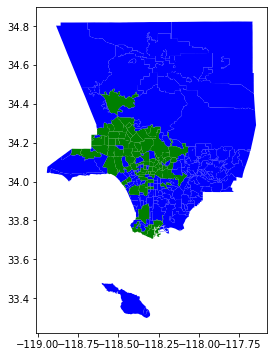

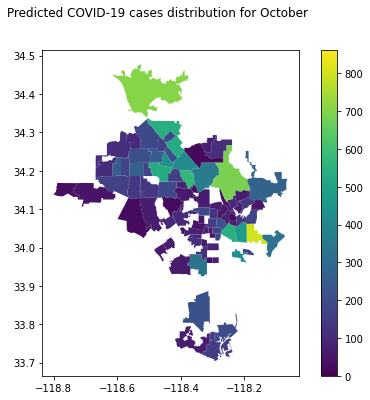

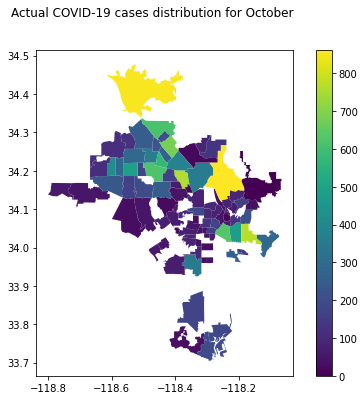

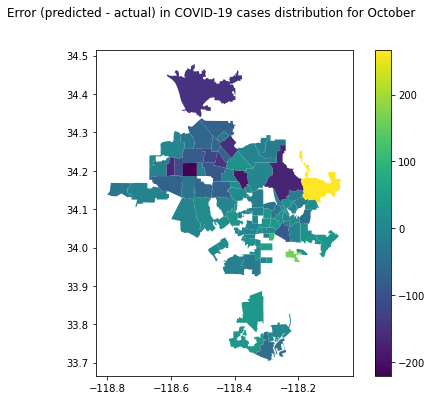

In [38]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, lin_model, "LinReg: 5-Month Window (with static)", wc5m_pty_arr, 5, used_regions)

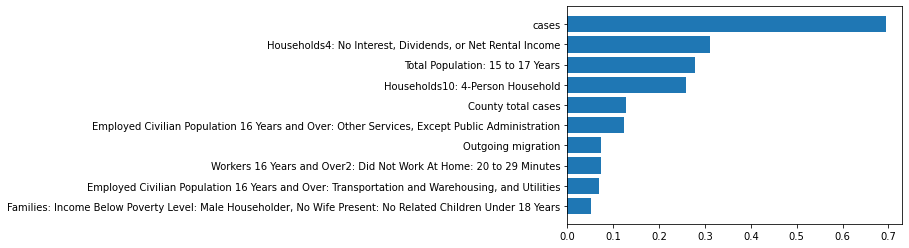

In [39]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [40]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [41]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

## 4-month window

### Feature Selection 1

In [42]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data, 4)
# lin_feat_subsets4_1 = f_selection(lin_model,wc4m_X_train_arr[0].shape[1],wc4m_X_train_arr[0], wc4m_X_test_arr[0], wc4m_y_train_arr[0], wc4m_y_test_arr[0], True)


In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets4_1.npy', lin_feat_subsets4_1, allow_pickle=True)

['Incoming migration' 'Outgoing migration' 'Area Total: Area (Water)'
 'Total Population: 55 to 64 Years' 'Total Population: 75 to 84 Years'
 'Total Population: 85 Years and Over'
 'Households: Family Households: Married-Couple Family'
 'Households: Nonfamily Households'
 'Households: Nonfamily Households: Male Householder'
 'Households: Nonfamily Households: Female Householder'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'Population 16 Years and Over: Not in Labor Force'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services'
 'Employed Civilian Population 16 Years and Over: Educational 

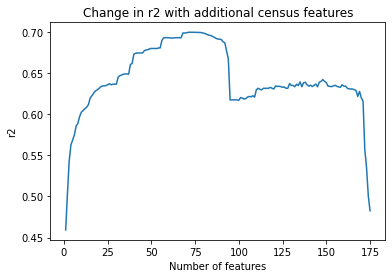

In [43]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets4_1.npy

lin_feat_subsets4_1 = np.load('../data/feat_selection/lin_feat_subsets4_1.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets4_1)

In [45]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

MSE: 21832.504863229005 
r2: 0.6140526018230823 
MAE: 103.2941652149732 
avg: 142.13186813186815


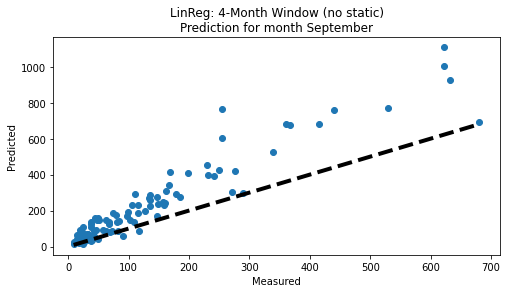

                    region    Predicted  Actual  Error
0          Adams-Normandie    93.370255      19     74
1             Agoura Hills    43.452850      13     30
2                   Arleta   342.606085     167    175
4          Atwater Village    63.222425      23     40
5   Baldwin Hills/Crenshaw   148.164171      50     98
9            Boyle Heights   762.358910     255    507
13             Canoga Park   396.630844     232    164
14              Chatsworth   134.310868      80     54
15               Chinatown   108.264320      23     85
16                Downtown  1004.229450     623    381
17              Eagle Rock   149.276549      61     88
19        East Los Angeles  1108.621153     622    486
20               Echo Park    88.543221      42     46
21               El Sereno   269.291477     133    136
22            Elysian Park    16.705179       8      8
23          Elysian Valley    77.909565      23     54
25           Glassell Park   144.684287      83     61
27        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


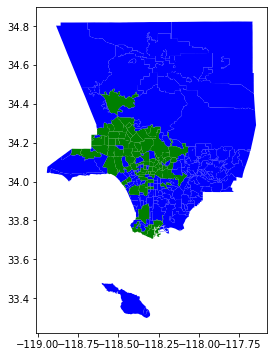

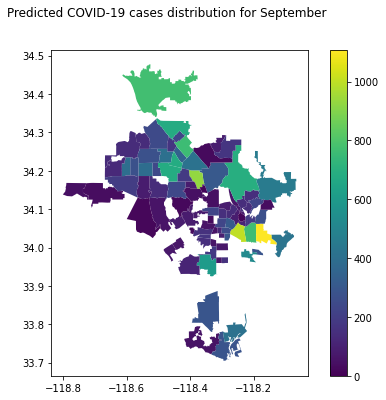

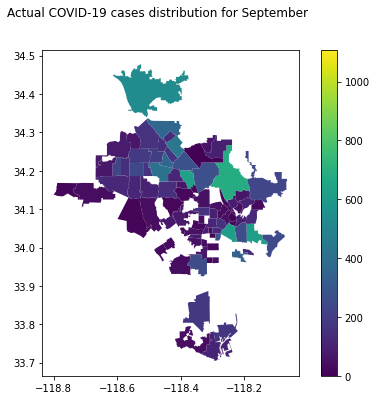

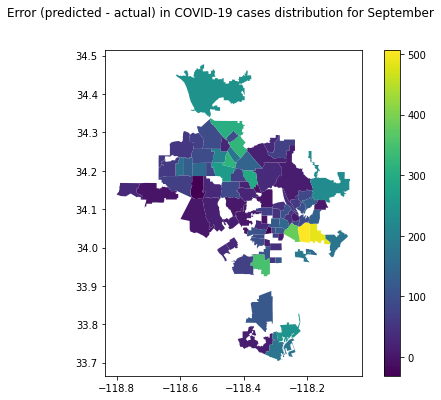

In [63]:
train_model_single(nc4m_X_train_arr[0], nc4m_X_test_arr[0], nc4m_y_train_arr[0], nc4m_y_test_arr[0], lin_model, "LinReg: 4-Month Window (no static)", 9, nc4m_pty_arr[0], used_regions)


MSE: 22787.6370754864 
r2: 0.6326269898951288 
MAE: 83.5034215589147 
avg: 142.13186813186815


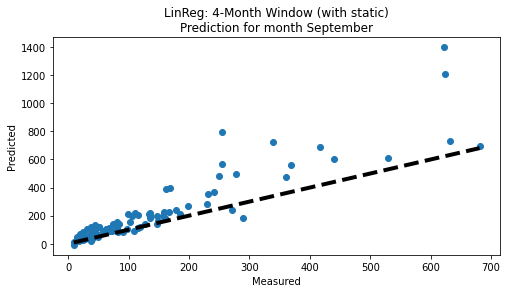

                    region    Predicted  Actual  Error
0          Adams-Normandie    70.603450      19     51
1             Agoura Hills    30.769859      13     17
4          Atwater Village    49.771527      23     26
5   Baldwin Hills/Crenshaw   120.779434      50     70
6            Beverly Crest    38.363903      21     17
9            Boyle Heights   797.012048     255    542
13             Canoga Park   357.344710     232    125
15               Chinatown    83.897442      23     60
16                Downtown  1210.088665     623    587
17              Eagle Rock   105.081148      61     44
18          East Hollywood   153.577686     101     52
19        East Los Angeles  1399.482990     622    777
20               Echo Park   100.646470      42     58
21               El Sereno   211.688106     133     78
22            Elysian Park    15.338860       8      7
23          Elysian Valley    68.846204      23     45
25           Glassell Park   139.100851      83     56
29        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


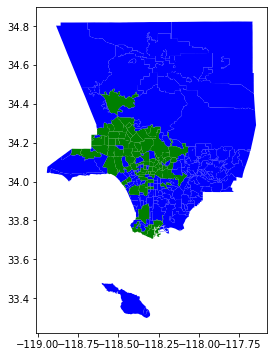

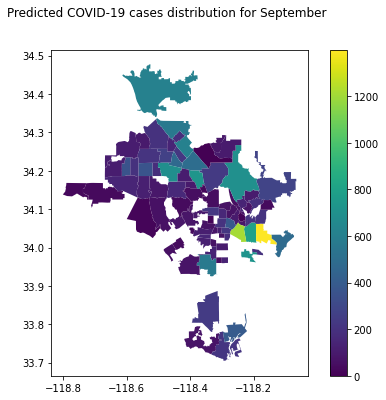

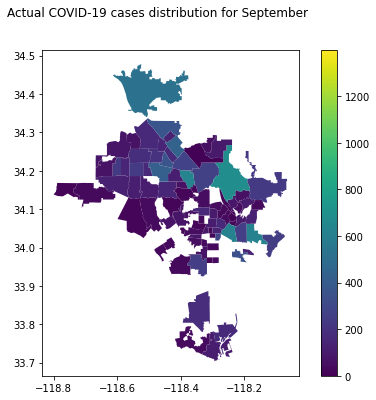

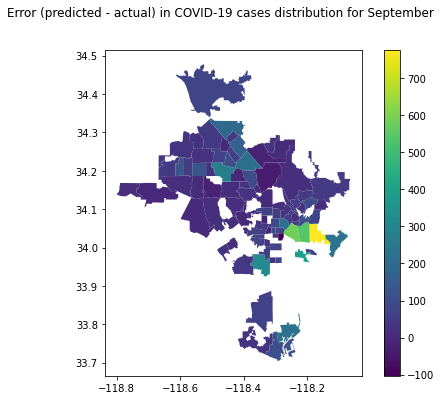

In [64]:
train_model_single(wc4m_X_train_arr[0], wc4m_X_test_arr[0], wc4m_y_train_arr[0], wc4m_y_test_arr[0], lin_model, "LinReg: 4-Month Window (with static)", 9, wc4m_pty_arr[0], used_regions)


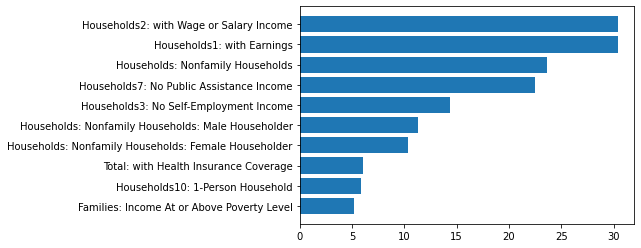

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 2

In [65]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data, 4)
# lin_feat_subsets4_2 = f_selection(lin_model,wc4m_X_train_arr[1].shape[1],wc4m_X_train_arr[1], wc4m_X_test_arr[1], wc4m_y_train_arr[1], wc4m_y_test_arr[1])


In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets4_2.npy', lin_feat_subsets4_2, allow_pickle=True)

['cases' 'Nursing home density' 'Healthcare workers'
 'Area Total: Area (Land)' 'Area Total: Area (Water)'
 'Total Population: Under 5 Years' 'Total Population: 5 to 9 Years'
 'Total Population: 10 to 14 Years' 'Total Population: 15 to 17 Years'
 'Total Population: 45 to 54 Years' 'Total Population: 55 to 64 Years'
 'Total Population: 65 to 74 Years' 'Households: Family Households'
 'Households: Family Households: Married-Couple Family'
 'Households: Family Households: Other Family'
 'Households: Family Households: Other Family: Male Householder, No Wife Present'
 'Households: Family Households: Other Family: Female Householder, No Husband Present'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Information'
 'Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasi

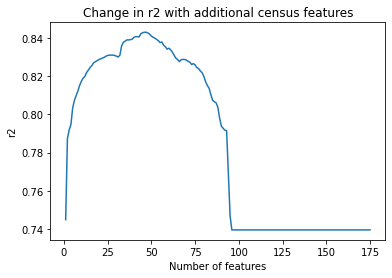

In [66]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets4_2.npy

lin_feat_subsets4_2 = np.load('../data/feat_selection/lin_feat_subsets4_2.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets4_2)

In [67]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

MSE: 5130.539028562702 
r2: 0.8556768007455078 
MAE: 46.114161779521524 
avg: 191.46153846153845


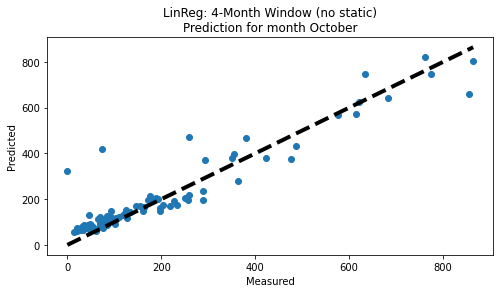

                 region   Predicted  Actual  Error
0       Adams-Normandie   67.881470      44     23
3     Arlington Heights  131.547708      44     87
4       Atwater Village   70.864542      33     37
6         Beverly Crest   69.647924      26     43
7         Beverly Hills  123.416583      69     54
8           Beverlywood   75.011077      29     46
10            Brentwood   87.469271      51     36
12            Calabasas   84.820299      49     35
18       East Hollywood  148.822326      92     56
20            Echo Park   89.663109      49     40
22         Elysian Park   58.086373      15     43
23       Elysian Valley   74.977845      44     30
25        Glassell Park  128.365958      84     44
28         Hancock Park   84.289708      33     51
29      Harvard Heights   82.994138      44     38
33      Huntington Park  473.233403     260    213
38         Leimert Park   85.705116      43     42
41    Manchester Square   63.420816      33     30
52    Pacific Palisades   66.10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


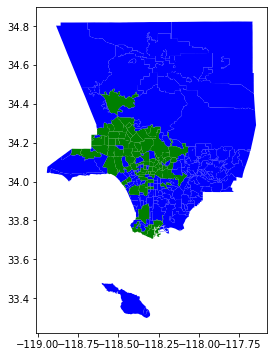

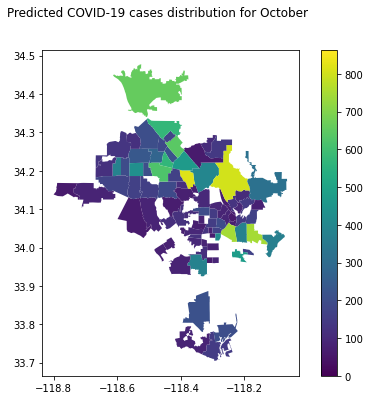

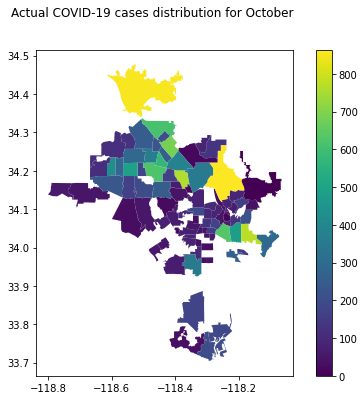

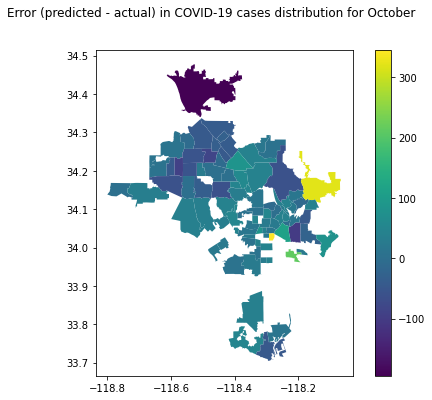

In [69]:
train_model_single(nc4m_X_train_arr[1], nc4m_X_test_arr[1], nc4m_y_train_arr[1], nc4m_y_test_arr[1], lin_model, "LinReg: 4-Month Window (no static)", 10, nc4m_pty_arr[1], used_regions)


MSE: 6267.911160012748 
r2: 0.7822990691378455 
MAE: 47.75448255628814 
avg: 191.46153846153845


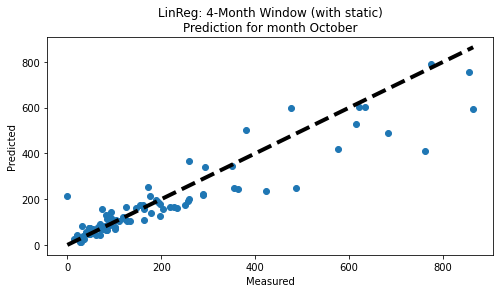

                    region   Predicted  Actual  Error
3        Arlington Heights   67.734903      44     23
5   Baldwin Hills/Crenshaw  129.165727      83     46
18          East Hollywood  142.142092      92     50
20               Echo Park   75.739804      49     26
22            Elysian Park   27.946805      15     12
23          Elysian Valley   68.191999      44     24
29         Harvard Heights   73.844037      44     29
55                Pasadena  215.508789       0    215
63            Shadow Hills   38.035540      20     18
72             Toluca Lake   44.739001      21     23
75         University Park  155.525482      73     82
80          Vermont Knolls   75.456574      44     31
81          Vermont Square   82.374269      31     51
        region  Predicted  Actual  Error
8  Beverlywood  11.032421      29    -17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


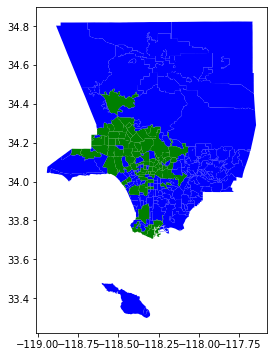

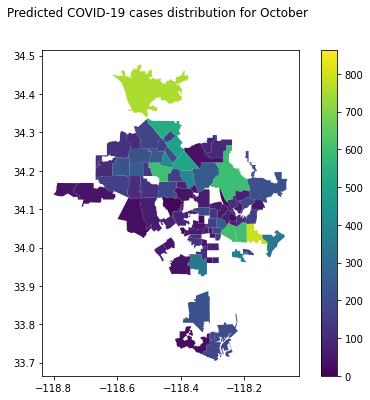

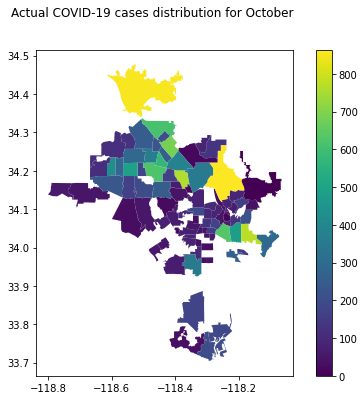

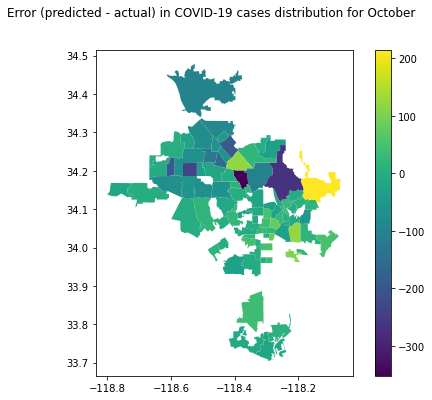

In [70]:
train_model_single(wc4m_X_train_arr[1], wc4m_X_test_arr[1], wc4m_y_train_arr[1], wc4m_y_test_arr[1], lin_model, "LinReg: 4-Month Window (with static)", 10, wc4m_pty_arr[1], used_regions)


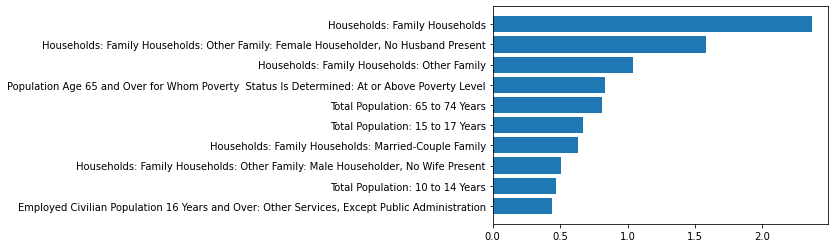

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

## 3-month window

### Feature Selection 1

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# lin_feat_subsets3_1 = f_selection(lin_model,wc3m_X_train_arr[0].shape[1],wc3m_X_train_arr[0], wc3m_X_test_arr[0], wc3m_y_train_arr[0], wc3m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets3_1.npy', lin_feat_subsets3_1, allow_pickle=True)

['Outgoing migration' 'Total jobs' 'Food Services workers'
 'Area Total: Area (Water)' 'Total Population: Under 5 Years'
 'Total Population: 5 to 9 Years' 'Total Population: 10 to 14 Years'
 'Total Population: 18 to 24 Years' 'Total Population: 25 to 34 Years'
 'Households: Family Households: Other Family: Female Householder, No Husband Present'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'Population 16 Years and Over: Not in Labor Force'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Manufacturing'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 'Employed Ci

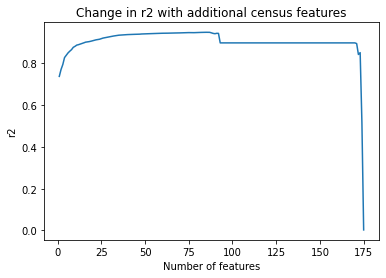

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets3_1.npy
lin_feat_subsets3_1 = np.load('../data/feat_selection/lin_feat_subsets3_1.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets3_1)

In [ ]:
month_data_oc, regions = build_month_data()

oc3m_X_train_arr, oc3m_X_test_arr, oc3m_y_train_arr, oc3m_y_test_arr, oc3m_ptX_arr, oc3m_pty_arr = n_month_window_split(month_data_oc, 3)
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

195


MSE: 375693.53056389076 
r2: 0.12639088513358931 
MAE: 435.07756604475315 
avg: 244.16483516483515


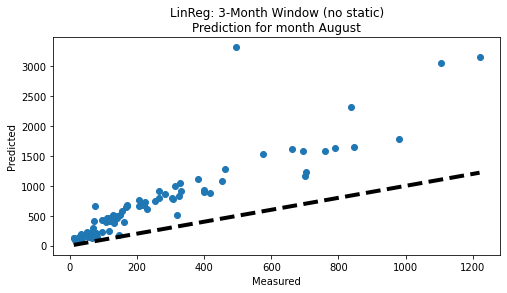

In [ ]:
train_model_single(nc3m_X_train_arr[0], nc3m_X_test_arr[0], nc3m_y_train_arr[0], nc3m_y_test_arr[0], lin_model, "LinReg: 3-Month Window (no static)", 8, nc3m_pty_arr[0])


MSE: 5860.214279815768 
r2: 0.9057870279149138 
MAE: 43.98574268853074 
avg: 244.16483516483515


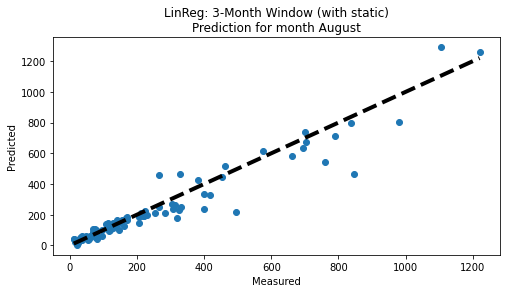

In [ ]:
train_model_single(wc3m_X_train_arr[0], wc3m_X_test_arr[0], wc3m_y_train_arr[0], wc3m_y_test_arr[0], lin_model, "LinReg: 3-Month Window (with static)", 8, wc3m_pty_arr[0])


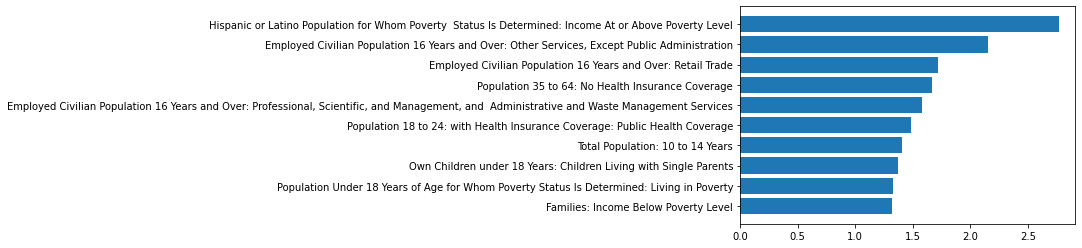

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 2

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# lin_feat_subsets3_2 = f_selection(lin_model,wc3m_X_train_arr[1].shape[1],wc3m_X_train_arr[1], wc3m_X_test_arr[1], wc3m_y_train_arr[1], wc3m_y_test_arr[1], True)

In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets3_2.npy', lin_feat_subsets3_2, allow_pickle=True)

['Incoming migration' 'Nursing home density' 'Total jobs'
 'Food Services workers' 'Area Total: Area (Land)'
 'Area Total: Area (Water)' 'Total Population: 10 to 14 Years'
 'Total Population: 15 to 17 Years' 'Total Population: 18 to 24 Years'
 'Total Population: 55 to 64 Years' 'Total Population: 65 to 74 Years'
 'Total Population: 75 to 84 Years'
 'Households: Family Households: Other Family'
 'Households: Family Households: Other Family: Female Householder, No Husband Present'
 'Households: Nonfamily Households: Female Householder'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'Population 16 Years and Over: Not in Labor Force'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Constr

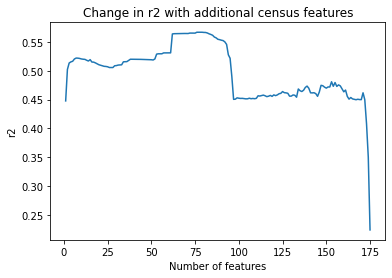

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets3_2.npy
lin_feat_subsets3_2 = np.load('../data/feat_selection/lin_feat_subsets3_2.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets3_2)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 19705.4763258411 
r2: 0.6239469820283815 
MAE: 100.3731113588032 
avg: 142.13186813186815


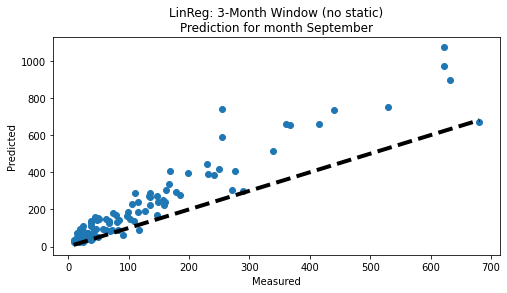

In [ ]:
train_model_single(nc3m_X_train_arr[1], nc3m_X_test_arr[1], nc3m_y_train_arr[1], nc3m_y_test_arr[1], lin_model, "LinReg: 3-Month Window (no static)", 9, nc3m_pty_arr[1])


MSE: 33023.1829364262 
r2: 0.5513380441133543 
MAE: 112.1098549189474 
avg: 142.13186813186815


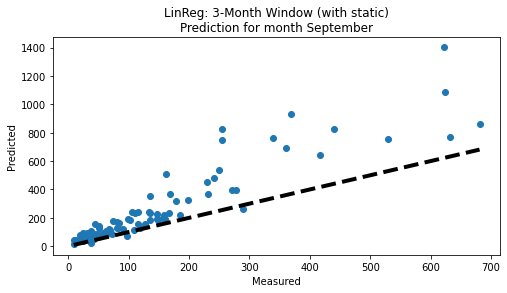

In [ ]:
train_model_single(wc3m_X_train_arr[1], wc3m_X_test_arr[1], wc3m_y_train_arr[1], wc3m_y_test_arr[1], lin_model, "LinReg: 3-Month Window (with static)", 9, wc3m_pty_arr[1])


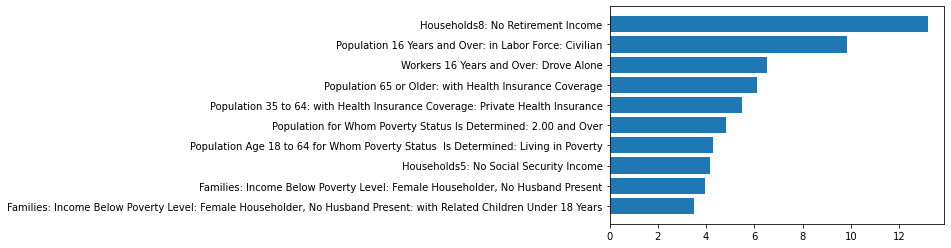

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 3

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# lin_feat_subsets3_3 = f_selection(lin_model,wc3m_X_train_arr[2].shape[1],wc3m_X_train_arr[2], wc3m_X_test_arr[2], wc3m_y_train_arr[2], wc3m_y_test_arr[2])

In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets3_3.npy', lin_feat_subsets3_3, allow_pickle=True)

['cases' 'Outgoing migration' 'Nursing home density' 'Total jobs'
 'Healthcare workers' 'Food Services workers' 'Area Total: Area (Water)'
 'Total Population: Under 5 Years' 'Total Population: 15 to 17 Years'
 'Total Population: 55 to 64 Years' 'Total Population: 65 to 74 Years'
 'Total Population: 85 Years and Over'
 'Households: Family Households: Married-Couple Family'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Manufacturing'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 'Employed Civilian Population 16 Years and Over: Information'
 'Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing'
 'Employed Civilian Population 16 Years and Over:

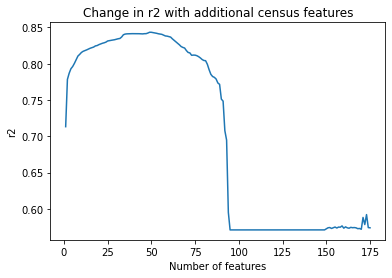

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets3_3.npy

lin_feat_subsets3_3 = np.load('../data/feat_selection/lin_feat_subsets3_3.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets3_3)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 48884.24816938173 
r2: 0.5083746819161818 
MAE: 164.01307702132922 
avg: 191.46153846153845


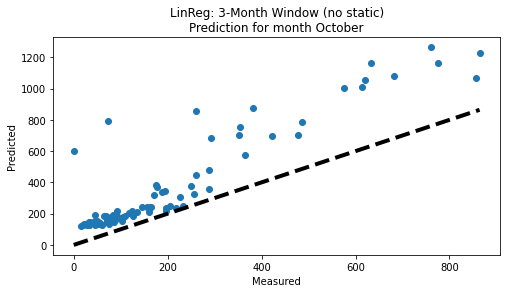

In [ ]:
train_model_single(nc3m_X_train_arr[2], nc3m_X_test_arr[2], nc3m_y_train_arr[2], nc3m_y_test_arr[2], lin_model, "LinReg: 3-Month Window (no static)", 10, nc3m_pty_arr[2])


MSE: 5974.055550883693 
r2: 0.7747064113384579 
MAE: 48.52228247375956 
avg: 191.46153846153845


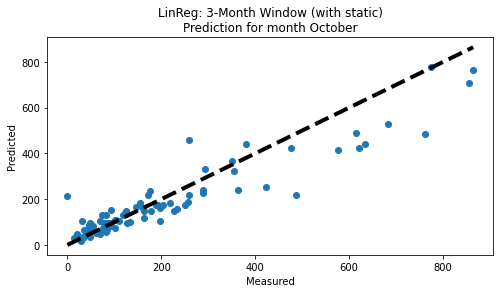

In [ ]:
train_model_single(wc3m_X_train_arr[2], wc3m_X_test_arr[2], wc3m_y_train_arr[2], wc3m_y_test_arr[2], lin_model, "LinReg: 3-Month Window (with static)", 10, wc3m_pty_arr[2])


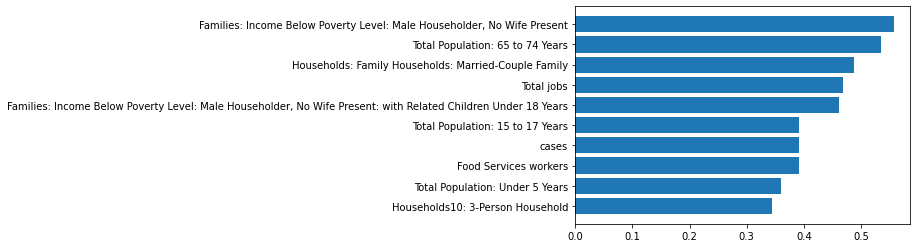

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

# SVR

In [71]:
svr_params = {
    'C': 1,
    'gamma': 0.0001,
    'kernel': 'linear',
}

# svr_params = {
#     'C': 1,
#     'gamma': 0.5,
#     'kernel': 'linear',
# }
svr_model = SVR(**svr_params)

### Cases Only

195
MSE: [70270.66061198719]; avg = 70270.66061198719 
r2: [-11.39244707990822]; avg = -11.39244707990822
MAE: [248.04136522674474]; avg = 248.04136522674474
avg: [160.03589743589743]; avg = 160.03589743589743


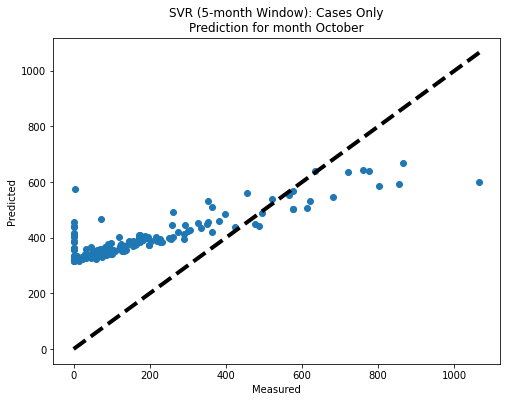

In [72]:
month_data, regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases Only", 5)

### Add Normalization

195
MSE: [8853.113618216325]; avg = 8853.113618216325 
r2: [0.7015831723749821]; avg = 0.7015831723749821
MAE: [51.90871646073913]; avg = 51.90871646073913
avg: [160.03589743589743]; avg = 160.03589743589743


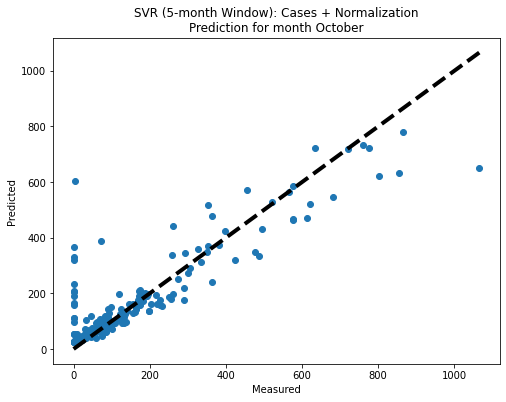

                    region   Predicted  Actual  Error
0                    Acton  110.953872       0    110
5            Angeles Crest   23.313360       0     23
8        Arlington Heights  117.173790      45     72
9                  Artesia  103.705733      32     71
10                  Athens   23.313360       0     23
12                  Avalon   26.397341       0     26
13         Avocado Heights  191.910597       0    191
17                 Bel-Air   40.795232      13     27
21           Beverly Crest   45.939993      26     19
22           Beverly Hills  107.846482      69     38
23             Beverlywood   52.115792      29     23
25                Bradbury   24.341307       6     18
30                  Carson  232.086597       0    232
32                 Castaic  196.268640     120     76
36           Cheviot Hills   42.852955      19     23
41                  Covina  366.339576       0    366
43             Culver City   53.145327       0     53
48                  Duarte  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


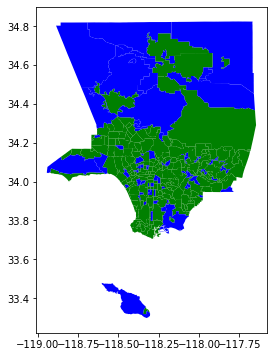

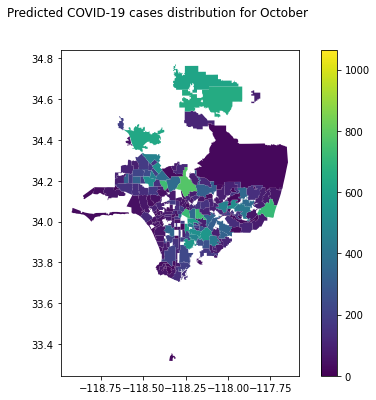

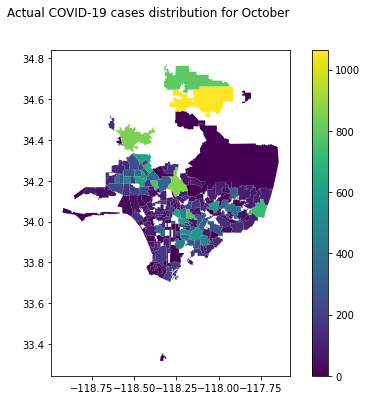

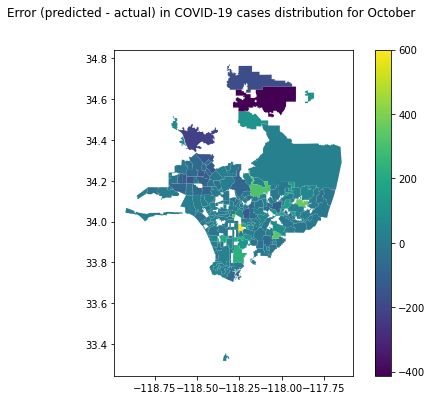

In [73]:
month_data, regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization", nc5m_pty_arr, 5, regions)

### Add Migration

91
MSE: [5572.850365295737]; avg = 5572.850365295737 
r2: [0.7943556625127766]; avg = 0.7943556625127766
MAE: [45.34599369349803]; avg = 45.34599369349803
avg: [191.46153846153845]; avg = 191.46153846153845


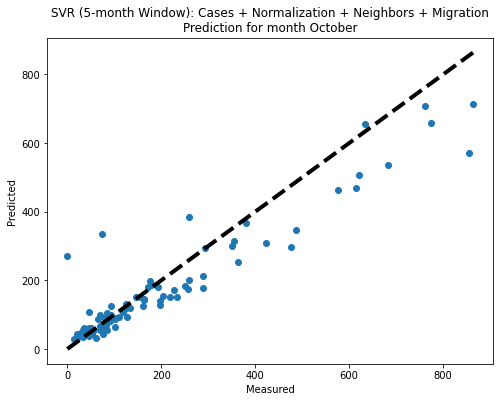

                 region   Predicted  Actual  Error
3     Arlington Heights  108.874544      44     64
6         Beverly Crest   40.524313      25     15
8           Beverlywood   46.492121      28     18
22         Elysian Park   27.685704      14     13
28         Hancock Park   56.633932      32     24
55             Pasadena  272.069921       0    272
58  Rancho Palos Verdes   60.054462      34     26
63         Shadow Hills   31.588413      19     12
72          Toluca Lake   43.494283      20     23
75      University Park  335.326407      72    263
81       Vermont Square   49.431470      30     19
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


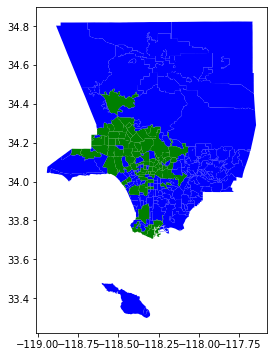

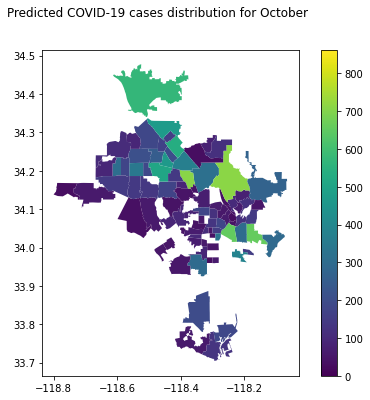

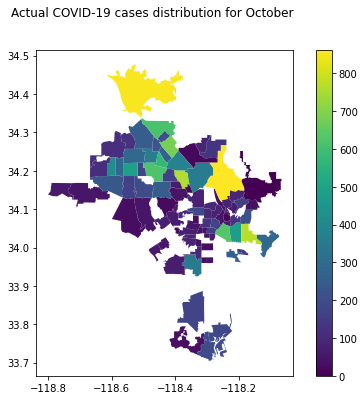

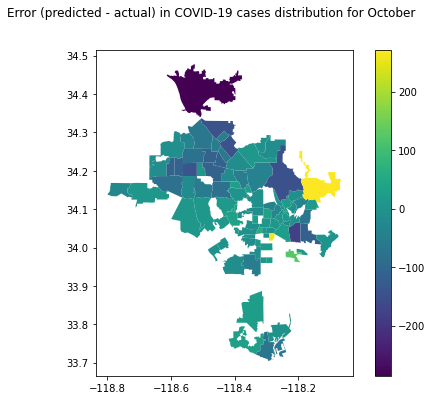

In [74]:
month_data, used_regions = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5, used_regions)

### Add Census

91
MSE: [10735.392888748103]; avg = 10735.392888748103 
r2: [0.7325609473360077]; avg = 0.7325609473360077
MAE: [62.35515147857249]; avg = 62.35515147857249
avg: [191.46153846153845]; avg = 191.46153846153845


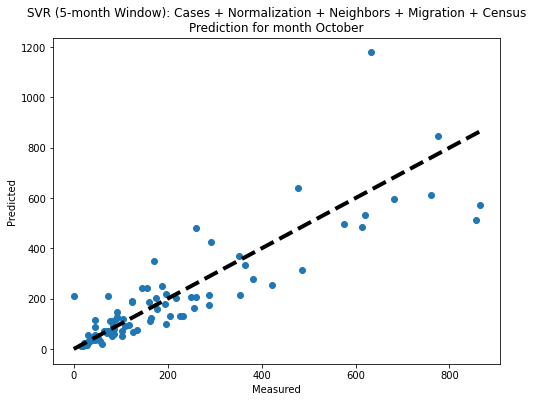

             region    Predicted  Actual  Error
16         Downtown  1178.559199     633    545
18   East Hollywood   147.259016      91     56
29  Harvard Heights    85.725641      44     41
33  Huntington Park   479.996521     260    219
36        Koreatown   189.650844     124     65
39  Lincoln Heights   185.521638     122     63
43          Maywood   240.407562     145     95
55         Pasadena   209.539081       0    209
56       Pico-Union   241.509735     155     86
75  University Park   209.358532      72    137
80   Vermont Knolls   116.944186      44     72
81   Vermont Square    54.069141      30     24
86         Westlake   351.464898     171    180
         region  Predicted  Actual  Error
1  Agoura Hills  21.268029      59    -37


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


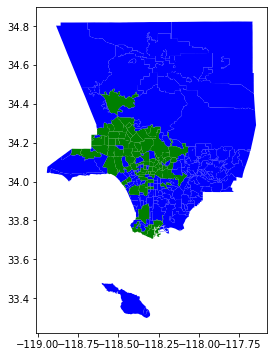

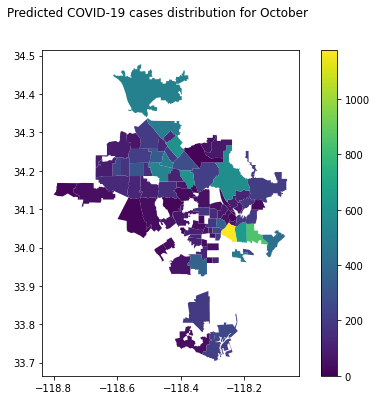

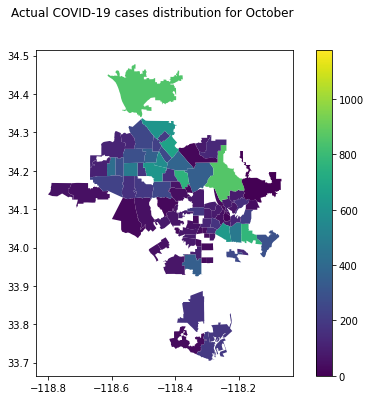

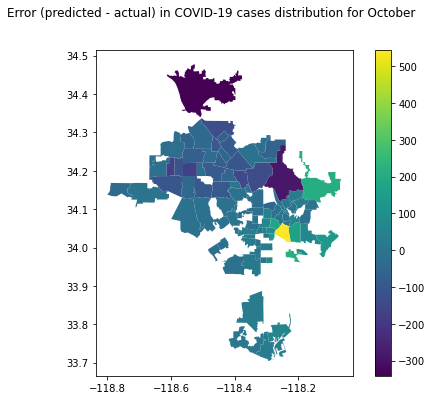

In [75]:
month_data, used_regions = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5, used_regions)

### Feature Selection

In [76]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [77]:
# nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
# svr_feat_subsets = f_selection(svr_model,nc5m_X_train_arr[0].shape[1],nc5m_X_train_arr[0],nc5m_y_train_arr[0])

In [78]:
# np.save('../data/svr_feat_subsets.npy',svr_feat_subsets, allow_pickle=True)

In [79]:
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets.npy
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]

91
['cases' 'County total cases' 'Total jobs'
 'Total Population: 35 to 44 Years'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 'Employed Civilian Population 16 Years and Over1: Private Non-Profit'
 'Households2: with Wage or Salary Income'
 'American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income At or Above Poverty Level'
 'Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level'
 'Workers 16 Years and Over: Motorcycle'
 'Workers 16 Years and Over2: Did Not Work At Home: Less than 10 Minutes'
 'Population 25 to 34: with Health Insurance Coverage: Public Health Coverage'
 'Households10: 1-Person Household']
0.6905949053914838


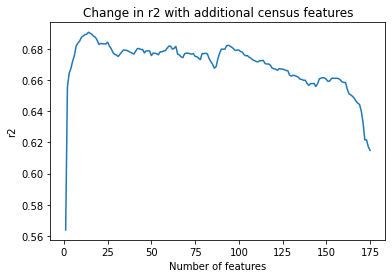

MSE: [6310.240045927749]; avg = 6310.240045927749 
r2: [0.8174618279214056]; avg = 0.8174618279214056
MAE: [47.21549120082157]; avg = 47.21549120082157
avg: [191.46153846153845]; avg = 191.46153846153845


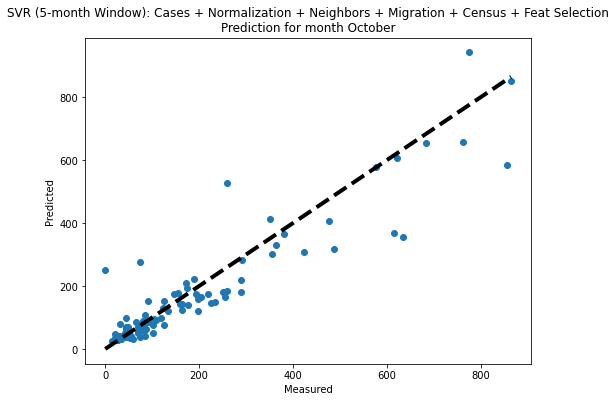

               region   Predicted  Actual  Error
3   Arlington Heights   98.357447      44     54
18     East Hollywood  153.118324      91     62
22       Elysian Park   26.672070      14     12
33    Huntington Park  525.699711     260    265
55           Pasadena  250.620830       0    250
63       Shadow Hills   34.397336      19     15
72        Toluca Lake   46.637799      20     26
75    University Park  274.728860      72    202
80     Vermont Knolls   71.193322      44     27
81     Vermont Square   78.548395      30     48
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


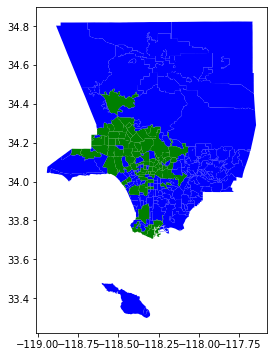

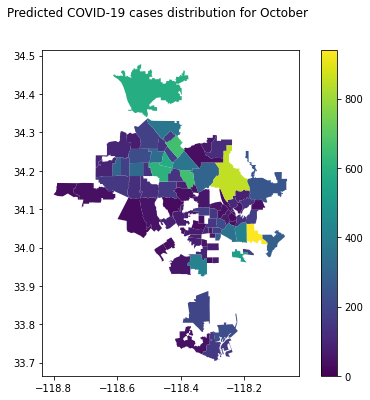

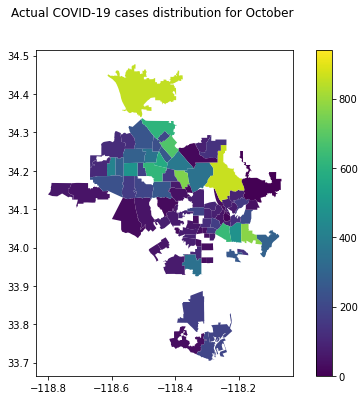

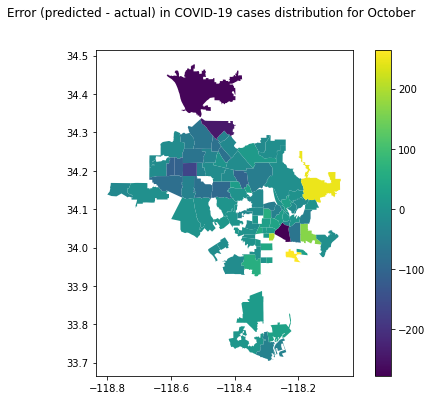

In [80]:
month_data, used_regions = build_month_data(False, True, True)
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ws, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration + Census + Feat Selection", nc5m_pty_arr, 5, used_regions)

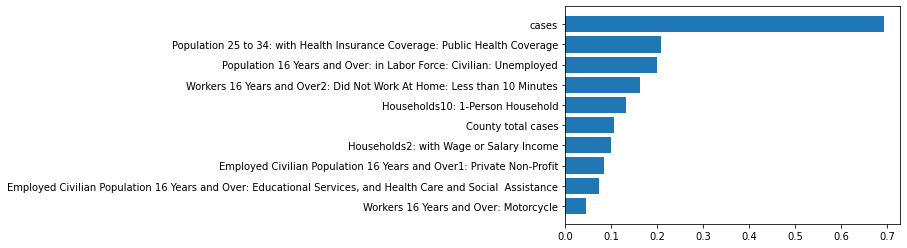

In [81]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [82]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [83]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [84]:
# svr_param_grid = {
#     'C':[1,5,10,20,30,50],
#     'gamma': [10,5, 1, 0.01, 0.0001],
#     'kernel': ['linear']
# }

# svr_model = SVR()
# svr_search = GridSearchCV(svr_model, svr_param_grid)

In [85]:
# search_model(nc5m_X_train_arr[0], nc5m_X_test_arr[0], nc5m_y_train_arr[0], nc5m_y_test_arr[0], svr_search, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection + Local Search")

In [86]:
# gb_search.best_estimator_

In [87]:
month_data_ns, used_regions = build_month_data(False, True)

91


## 5-month window

### Feature Selection

In [88]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data, 5)
# svr_feat_subsets5 = f_selection(svr_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_X_test_arr[0],wc5m_y_train_arr[0],wc5m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets5.npy', svr_feat_subsets5, allow_pickle=True)

['cases' 'County total cases' 'Outgoing migration' 'Nursing home density'
 'Total jobs' 'Healthcare workers' 'Total Population: 35 to 44 Years'
 'Households: Family Households'
 'Population 16 Years and Over: in Labor Force: Civilian: Employed'
 'In Labor Force 16 Years and Over: Civilian'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 'Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 'Employed Civilian Population 16 Years and Over: Public Administration'
 'Employed Civilian Population 16 Years and Over1: Public Sector'
 'Employed Civilian Population 16 Years and Over1: Private Non-Profit'
 'Households4: No Interest, Dividends, or Net Rental Income'
 'Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level'
 'Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Pove

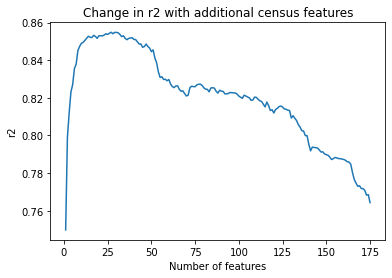

In [89]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets5.npy

svr_feat_subsets5 = np.load('../data/feat_selection/svr_feat_subsets5.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets5)

In [90]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

MSE: [5572.850365295737]; avg = 5572.850365295737 
r2: [0.7943556625127766]; avg = 0.7943556625127766
MAE: [45.34599369349803]; avg = 45.34599369349803
avg: [191.46153846153845]; avg = 191.46153846153845


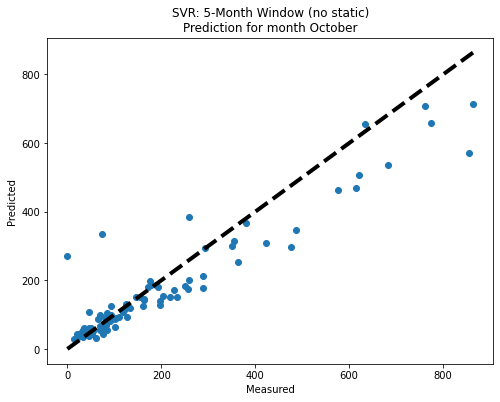

                 region   Predicted  Actual  Error
3     Arlington Heights  108.874544      44     64
6         Beverly Crest   40.524313      25     15
8           Beverlywood   46.492121      28     18
22         Elysian Park   27.685704      14     13
28         Hancock Park   56.633932      32     24
55             Pasadena  272.069921       0    272
58  Rancho Palos Verdes   60.054462      34     26
63         Shadow Hills   31.588413      19     12
72          Toluca Lake   43.494283      20     23
75      University Park  335.326407      72    263
81       Vermont Square   49.431470      30     19
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


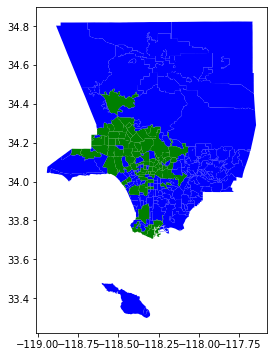

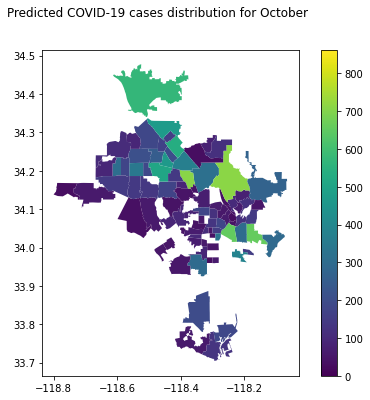

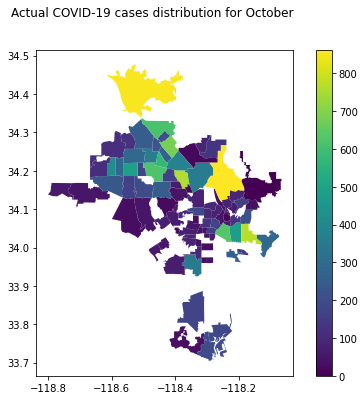

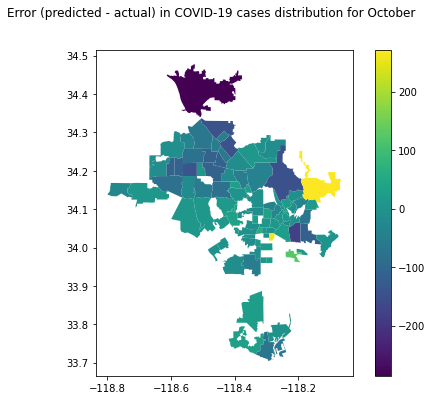

In [91]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR: 5-Month Window (no static)", nc5m_pty_arr, 5, used_regions)

MSE: [4392.830421568989]; avg = 4392.830421568989 
r2: [0.8482452473554225]; avg = 0.8482452473554225
MAE: [42.801269483824896]; avg = 42.801269483824896
avg: [191.46153846153845]; avg = 191.46153846153845


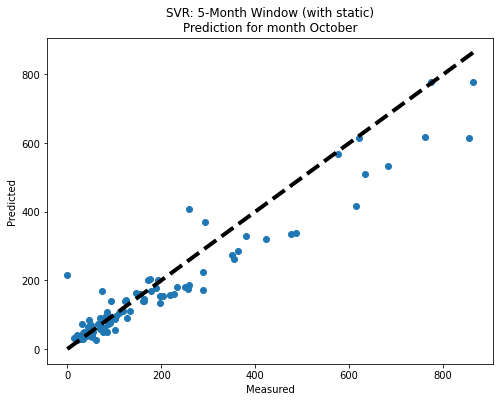

               region   Predicted  Actual  Error
3   Arlington Heights   84.741650      44     40
18     East Hollywood  139.922566      91     48
22       Elysian Park   30.611177      14     16
33    Huntington Park  406.851750     260    146
38       Leimert Park   65.254811      42     23
55           Pasadena  214.838731       0    214
72        Toluca Lake   40.490481      20     20
75    University Park  169.033859      72     97
81     Vermont Square   72.424294      30     42
         region  Predicted  Actual  Error
1  Agoura Hills  24.889201      59    -34


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


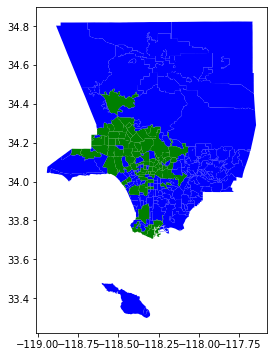

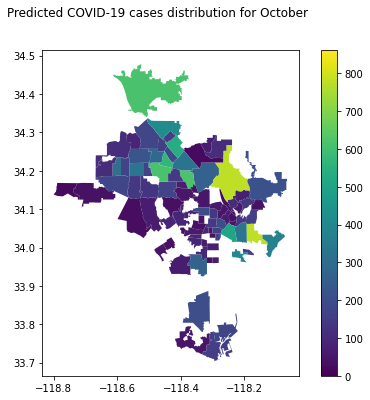

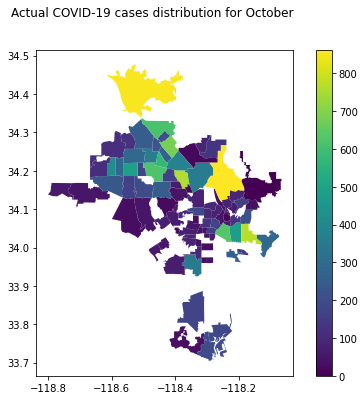

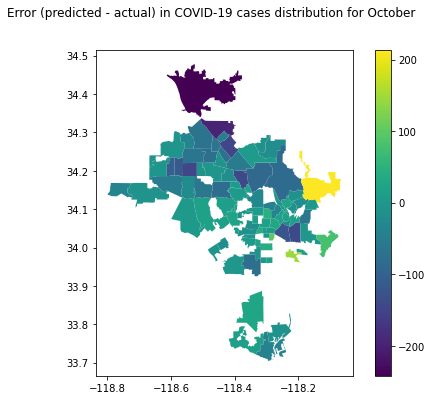

In [92]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, svr_model, "SVR: 5-Month Window (with static)", wc5m_pty_arr, 5, used_regions)

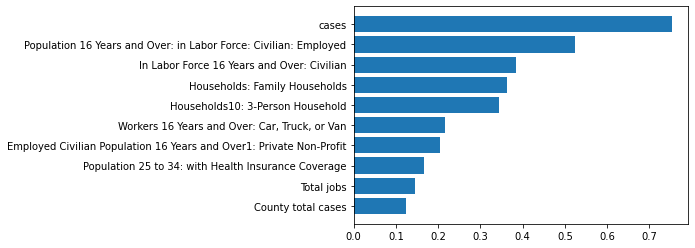

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

## 4-month window

### Feature Selection 1

In [93]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [94]:
# wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data, 4)
# svr_feat_subsets4_1 = f_selection(svr_model,wc4m_X_train_arr[0].shape[1],wc4m_X_train_arr[0], wc4m_X_test_arr[0], wc4m_y_train_arr[0], wc4m_y_test_arr[0])

In [95]:
# np.save('../data/feat_selection/svr_feat_subsets4_1.npy', svr_feat_subsets4_1, allow_pickle=True)

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Healthcare workers' 'Food Services workers' 'Area Total: Area (Land)'
 'Area Total: Area (Water)' 'Total Population: Under 5 Years'
 'Total Population: 25 to 34 Years' 'Total Population: 35 to 44 Years'
 'Total Population: 45 to 54 Years' 'Total Population: 55 to 64 Years'
 'Total Population: 65 to 74 Years' 'Total Population: 85 Years and Over'
 'Households: Family Households'
 'Households: Nonfamily Households: Male Householder'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 '

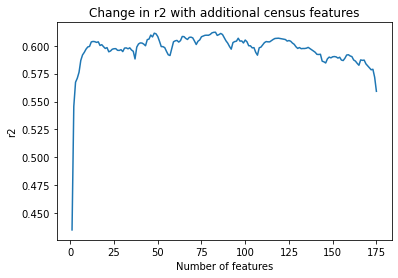

In [96]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets4_1.npy

svr_feat_subsets4_1 = np.load('../data/feat_selection/svr_feat_subsets4_1.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets4_1)

In [97]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

MSE: 23040.661730326796 
r2: 0.6175204891100375 
MAE: 103.11713823216432 
avg: 142.13186813186815


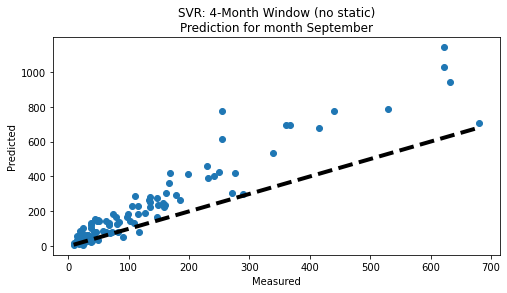

                    region    Predicted  Actual  Error
0          Adams-Normandie    87.428069      19     68
1             Agoura Hills    35.907410      13     22
2                   Arleta   364.069928     167    197
4          Atwater Village    53.693317      23     30
5   Baldwin Hills/Crenshaw   143.843769      50     93
9            Boyle Heights   776.316500     255    521
13             Canoga Park   393.108878     232    161
14              Chatsworth   129.865275      80     49
15               Chinatown   103.107815      23     80
16                Downtown  1029.530719     623    406
17              Eagle Rock   142.751950      61     81
19        East Los Angeles  1140.763783     622    518
20               Echo Park    80.752745      42     38
21               El Sereno   265.964666     133    132
23          Elysian Valley    72.757932      23     49
25           Glassell Park   139.226317      83     56
27           Granada Hills   246.771846     157     89
29        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


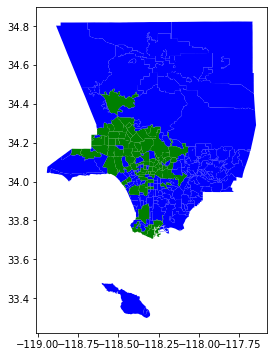

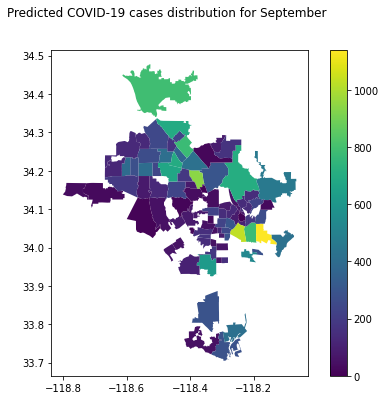

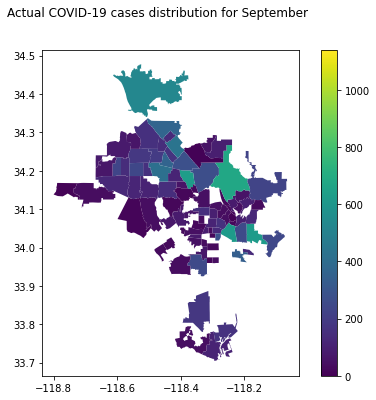

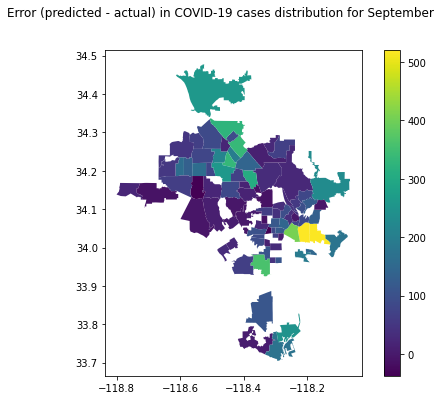

In [99]:
train_model_single(nc4m_X_train_arr[0], nc4m_X_test_arr[0], nc4m_y_train_arr[0], nc4m_y_test_arr[0], svr_model, "SVR: 4-Month Window (no static)", 9, nc4m_pty_arr[0], used_regions)


MSE: 23883.33107287843 
r2: 0.5969990837072365 
MAE: 97.13925254834338 
avg: 142.13186813186815


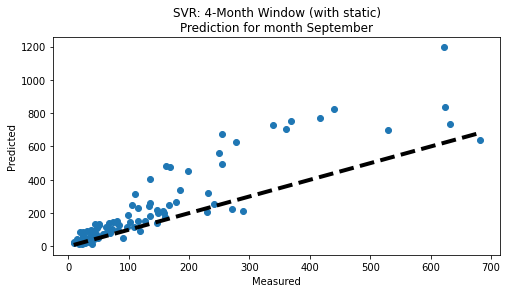

                    region    Predicted  Actual  Error
0          Adams-Normandie    85.071030      19     66
1             Agoura Hills    29.351570      13     16
4          Atwater Village    55.179246      23     32
5   Baldwin Hills/Crenshaw   132.592847      50     82
9            Boyle Heights   673.534763     255    418
10               Brentwood    64.144253      41     23
14              Chatsworth   138.803347      80     58
15               Chinatown    88.310278      23     65
17              Eagle Rock   117.301586      61     56
19        East Los Angeles  1195.909584     622    573
20               Echo Park    95.156494      42     53
21               El Sereno   240.520776     133    107
22            Elysian Park    19.966508       8     11
23          Elysian Valley    70.208090      23     47
25           Glassell Park   128.428051      83     45
29         Harvard Heights   100.254577      36     64
30           Highland Park   249.342825     104    145
33        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


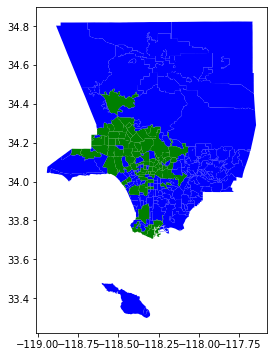

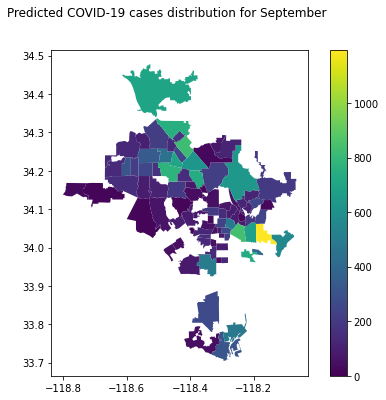

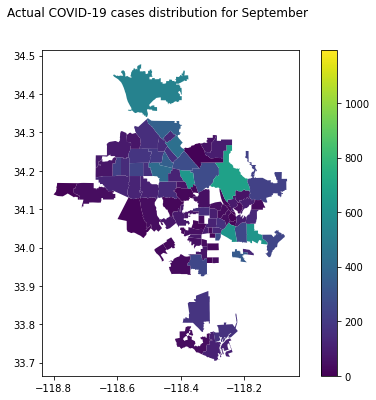

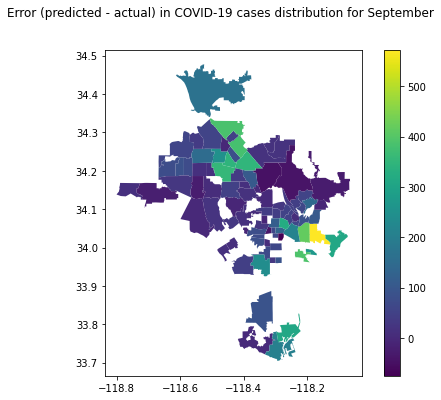

In [100]:
train_model_single(wc4m_X_train_arr[0], wc4m_X_test_arr[0], wc4m_y_train_arr[0], wc4m_y_test_arr[0], svr_model, "SVR: 4-Month Window (with static)", 9, wc4m_pty_arr[0], used_regions)


In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 2

In [101]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data, 4)
# svr_feat_subsets4_2 = f_selection(svr_model,wc4m_X_train_arr[1].shape[1],wc4m_X_train_arr[1], wc4m_X_test_arr[1], wc4m_y_train_arr[1], wc4m_y_test_arr[1])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets4_2.npy', svr_feat_subsets4_2, allow_pickle=True)

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Area Total: Area (Water)' 'Total Population: Under 5 Years'
 'Total Population: 10 to 14 Years' 'Total Population: 15 to 17 Years'
 'Households: Family Households: Other Family: Female Householder, No Husband Present'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 'Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration'
 'Employed Civilian Population 16 Years and Over1: Private Sector'
 'Employed Civilian Population 16 Years and Over1: Private Non-Profit'
 'Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years'
 'Population Age 65 and Over for Whom Poverty  Status Is Determined:

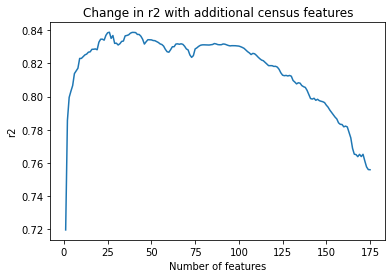

In [102]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets4_2.npy

svr_feat_subsets4_2 = np.load('../data/feat_selection/svr_feat_subsets4_2.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets4_2)

In [103]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

MSE: 5222.455068447241 
r2: 0.8305160366677737 
MAE: 45.50464077051327 
avg: 191.46153846153845


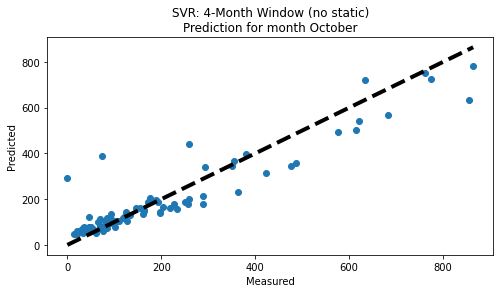

                 region   Predicted  Actual  Error
3     Arlington Heights  121.672370      44     77
4       Atwater Village   58.217665      33     25
6         Beverly Crest   58.437994      26     32
7         Beverly Hills  113.384692      69     44
8           Beverlywood   63.931289      29     34
20            Echo Park   77.011874      49     28
22         Elysian Park   46.606122      15     31
28         Hancock Park   73.163180      33     40
29      Harvard Heights   72.081052      44     28
33      Huntington Park  441.821392     260    181
38         Leimert Park   74.864178      43     31
41    Manchester Square   52.066315      33     19
52    Pacific Palisades   54.817317      28     26
55             Pasadena  292.819083       0    292
58  Rancho Palos Verdes   76.526281      35     41
63         Shadow Hills   48.583435      20     28
66       South Pasadena   69.400729      39     30
72          Toluca Lake   60.602925      21     39
75      University Park  387.60

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


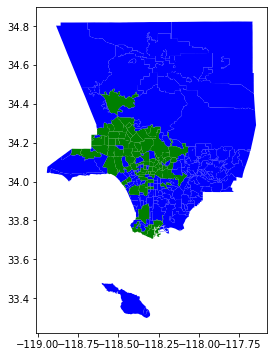

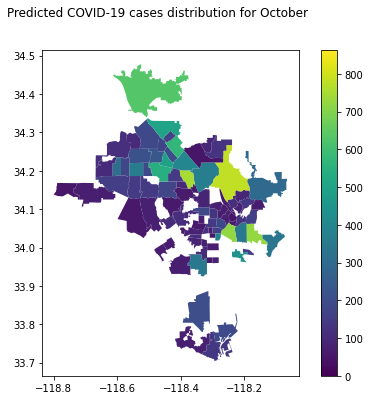

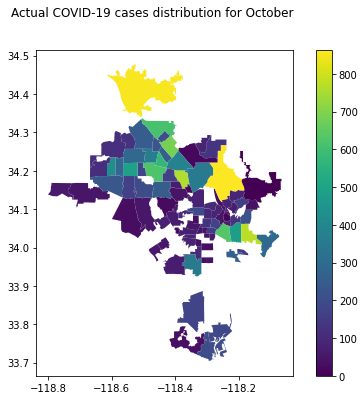

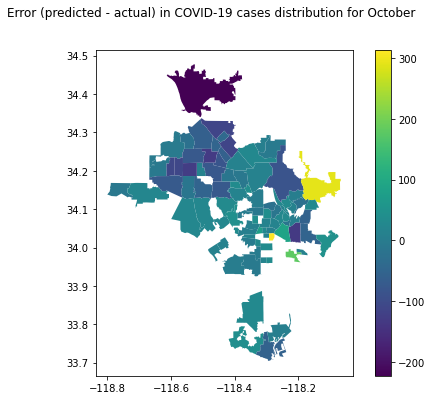

In [104]:
train_model_single(nc4m_X_train_arr[1], nc4m_X_test_arr[1], nc4m_y_train_arr[1], nc4m_y_test_arr[1], svr_model, "SVR: 4-Month Window (no static)", 10, nc4m_pty_arr[1], used_regions)


MSE: 4293.378530023202 
r2: 0.8761093600049319 
MAE: 43.57593143959251 
avg: 191.46153846153845


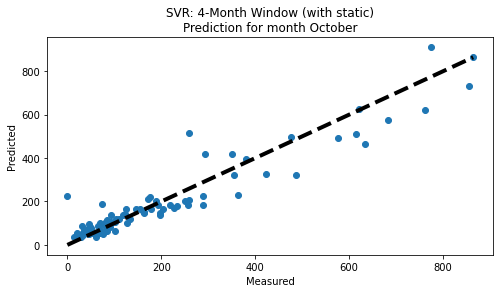

                 region   Predicted  Actual  Error
3     Arlington Heights   95.371785      44     51
4       Atwater Village   55.988463      33     22
6         Beverly Crest   43.687664      26     17
8           Beverlywood   44.995850      29     15
20            Echo Park   82.121712      49     33
22         Elysian Park   36.857930      15     21
28         Hancock Park   56.051478      33     23
33      Huntington Park  516.790917     260    256
55             Pasadena  226.353026       0    226
58  Rancho Palos Verdes   73.392699      35     38
63         Shadow Hills   46.869460      20     26
67          Studio City   72.153445      44     28
72          Toluca Lake   53.382129      21     32
75      University Park  190.526968      73    117
80       Vermont Knolls   79.812359      44     35
81       Vermont Square   88.366138      31     57
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


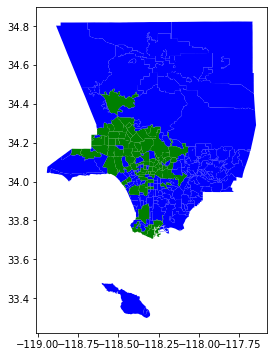

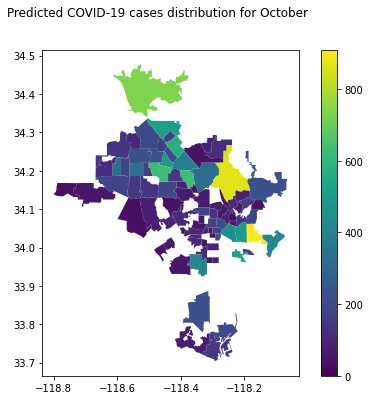

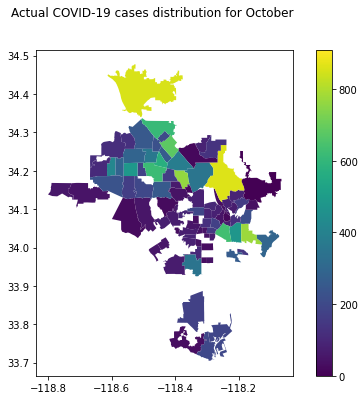

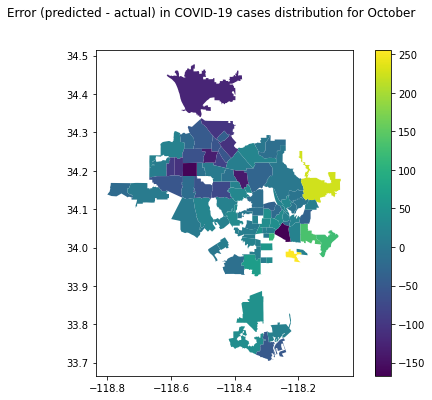

In [105]:
train_model_single(wc4m_X_train_arr[1], wc4m_X_test_arr[1], wc4m_y_train_arr[1], wc4m_y_test_arr[1], svr_model, "SVR: 4-Month Window (with static)", 10, wc4m_pty_arr[1], used_regions)


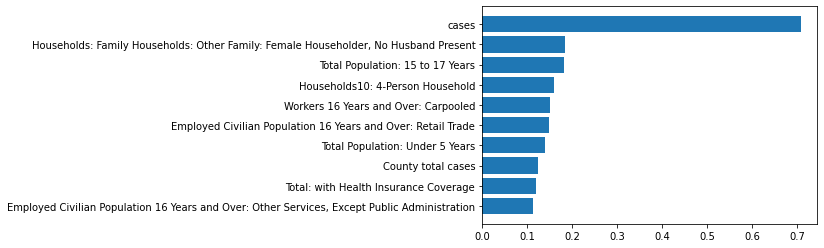

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

## 3-month window

### Feature Selection 1

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# svr_feat_subsets3_1 = f_selection(svr_model,wc3m_X_train_arr[0].shape[1],wc3m_X_train_arr[0], wc3m_X_test_arr[0], wc3m_y_train_arr[0], wc3m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets3_1.npy', svr_feat_subsets3_1, allow_pickle=True)

['Outgoing migration' 'Food Services workers' 'Area Total: Area (Land)'
 'Area Total: Area (Water)' 'Total Population: 5 to 9 Years'
 'Total Population: 10 to 14 Years' 'Total Population: 15 to 17 Years'
 'Total Population: 18 to 24 Years' 'Total Population: 35 to 44 Years'
 'Total Population: 45 to 54 Years' 'Total Population: 85 Years and Over'
 'Population 16 Years and Over: in Labor Force'
 'Population 16 Years and Over: in Labor Force: Civilian'
 'Population 16 Years and Over: in Labor Force: Civilian: Employed'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'Population 16 Years and Over: Not in Labor Force'
 'In Labor Force 16 Years and Over: Civilian'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Manufacturing'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Transportation and Wareh

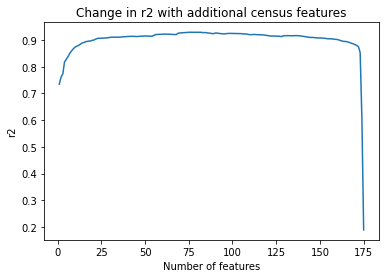

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets3_1.npy

svr_feat_subsets3_1 = np.load('../data/feat_selection/svr_feat_subsets3_1.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets3_1)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 380620.17674176436 
r2: 0.10868759324388144 
MAE: 444.69050230715925 
avg: 244.16483516483515


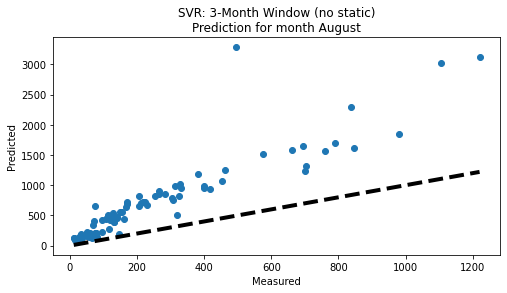

In [ ]:
train_model_single(nc3m_X_train_arr[0], nc3m_X_test_arr[0], nc3m_y_train_arr[0], nc3m_y_test_arr[0], svr_model, "SVR: 3-Month Window (no static)", 8, nc3m_pty_arr[0])


MSE: 8286.441751057131 
r2: 0.8584389341790271 
MAE: 51.06522725154266 
avg: 244.16483516483515


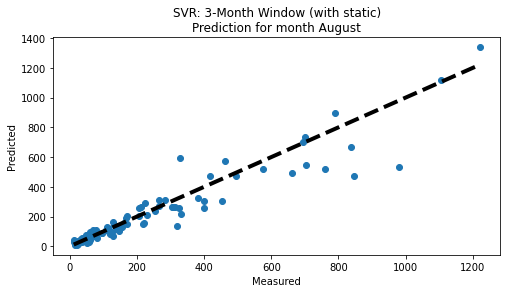

In [ ]:
train_model_single(wc3m_X_train_arr[0], wc3m_X_test_arr[0], wc3m_y_train_arr[0], wc3m_y_test_arr[0], svr_model, "SVR: 3-Month Window (with static)", 8, wc3m_pty_arr[0])


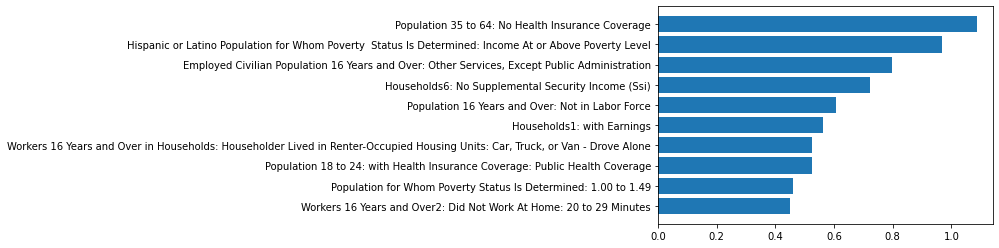

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 2

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# svr_feat_subsets3_2 = f_selection(svr_model,wc3m_X_train_arr[1].shape[1],wc3m_X_train_arr[1], wc3m_X_test_arr[1], wc3m_y_train_arr[1], wc3m_y_test_arr[1])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets3_2.npy', svr_feat_subsets3_2, allow_pickle=True)

['cases' 'County total cases' 'Healthcare workers'
 'Area Total: Area (Land)' 'Total Population: 35 to 44 Years'
 'Households: Nonfamily Households: Male Householder'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 'Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 'Employed Civilian Population 16 Years and Over1: Public Sector'
 'Employed Civilian Population 16 Years and Over1: Private Non-Profit'
 'American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income At or Above Poverty Level'
 'Asian Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level'
 'Workers 16 Years and Over: Car, Truck, or Van'
 'Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units'
 'Workers 16 Years and Over2: Did Not Work At Home: 10 to 19 Minutes'
 'Workers 16 Years 

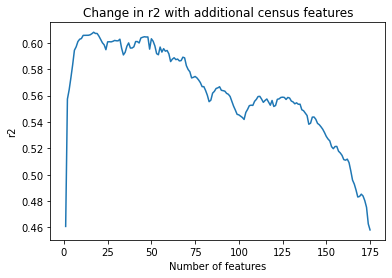

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets3_2.npy

svr_feat_subsets3_2 = np.load('../data/feat_selection/svr_feat_subsets3_2.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets3_2)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 20899.987462813984 
r2: 0.6339261662365292 
MAE: 98.73454200537944 
avg: 142.13186813186815


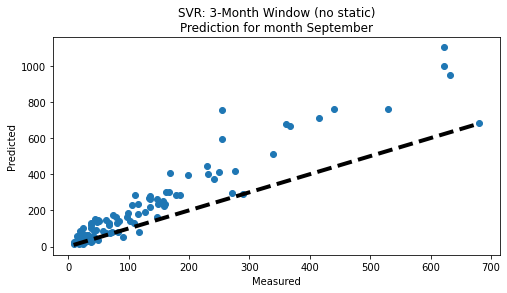

In [ ]:
train_model_single(nc3m_X_train_arr[1], nc3m_X_test_arr[1], nc3m_y_train_arr[1], nc3m_y_test_arr[1], svr_model, "SVR: 3-Month Window (no static)", 9, nc3m_pty_arr[1])


MSE: 18178.53888271146 
r2: 0.6505913264472312 
MAE: 92.56874958939024 
avg: 142.13186813186815


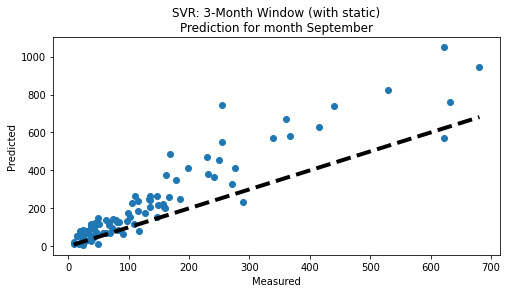

In [ ]:
train_model_single(wc3m_X_train_arr[1], wc3m_X_test_arr[1], wc3m_y_train_arr[1], wc3m_y_test_arr[1], svr_model, "SVR: 3-Month Window (with static)", 9, wc3m_pty_arr[1])


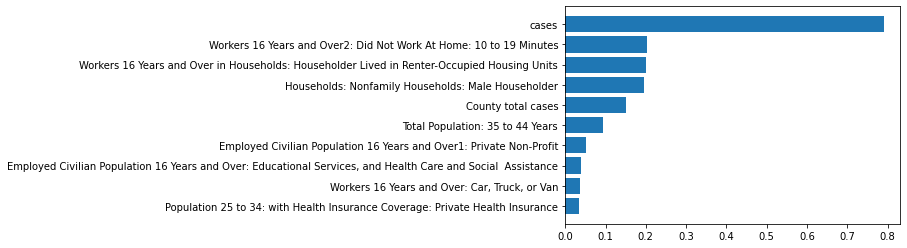

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 3

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

91
91


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# svr_feat_subsets3_3 = f_selection(svr_model,wc3m_X_train_arr[2].shape[1],wc3m_X_train_arr[2], wc3m_X_test_arr[2], wc3m_y_train_arr[2], wc3m_y_test_arr[2])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets3_3.npy', svr_feat_subsets3_3, allow_pickle=True)

['cases' 'Incoming migration' 'Outgoing migration' 'Nursing home density'
 'Area Total: Area (Land)' 'Area Total: Area (Water)'
 'Total Population: Under 5 Years' 'Total Population: 5 to 9 Years'
 'Total Population: 10 to 14 Years' 'Total Population: 15 to 17 Years'
 'Households: Family Households: Other Family: Male Householder, No Wife Present'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'Population 16 Years and Over: Not in Labor Force'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Manufacturing'
 'Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 'Employed Civilian Population 16 Years and Over1: Private Non-Profit'
 'Employ

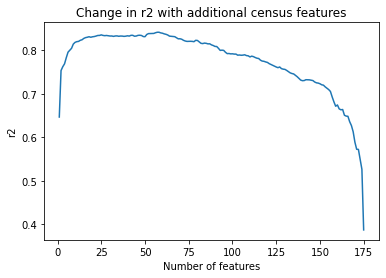

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets3_3.npy
svr_feat_subsets3_3 = np.load('../data/feat_selection/svr_feat_subsets3_3.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets3_3)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 43887.98360790211 
r2: 0.559107833166558 
MAE: 148.14954840753248 
avg: 191.46153846153845


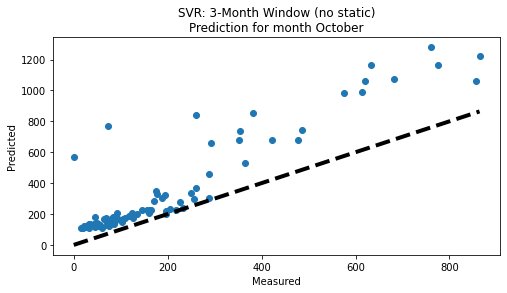

In [ ]:
train_model_single(nc3m_X_train_arr[2], nc3m_X_test_arr[2], nc3m_y_train_arr[2], nc3m_y_test_arr[2], svr_model, "SVR: 3-Month Window (no static)", 10, nc3m_pty_arr[2])


MSE: 6694.089313874653 
r2: 0.7005139939140861 
MAE: 50.92511252981898 
avg: 191.46153846153845


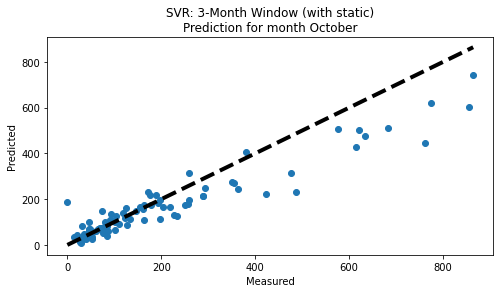

In [ ]:
train_model_single(wc3m_X_train_arr[2], wc3m_X_test_arr[2], wc3m_y_train_arr[2], wc3m_y_test_arr[2], svr_model, "SVR: 3-Month Window (with static)", 10, wc3m_pty_arr[2])


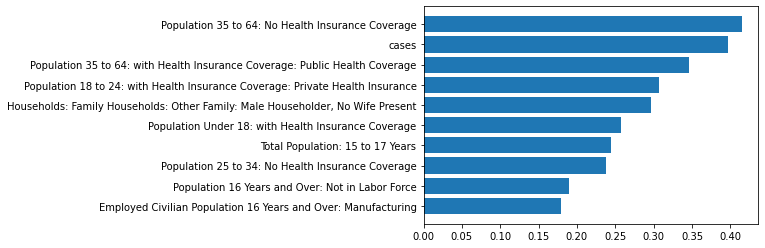

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

# GBR

In [ ]:
gb_param = {
#     'n_estimators': 700,
#     'max_depth': 16,
#     'min_samples_split': 100,
#     'learning_rate': 0.01,
#     'loss': 'ls'
}
gb_model = GradientBoostingRegressor(**gb_param)

### Cases Only

195
MSE: [12544.07137254315]; avg = 12544.07137254315 
r2: [0.7499153095828812]; avg = 0.7499153095828812
MAE: [62.94000478474417]; avg = 62.94000478474417
avg: [160.03589743589743]; avg = 160.03589743589743


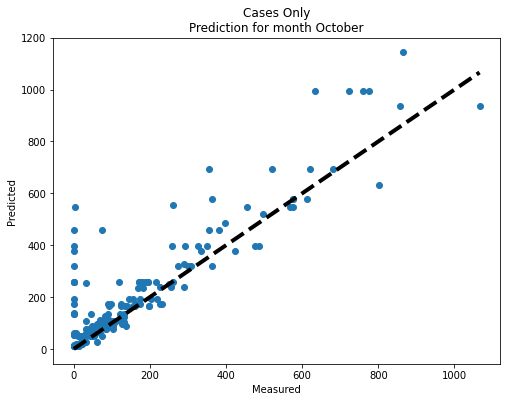

In [ ]:
month_data, used_regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases Only", 5)

### Add Normalization

195
MSE: [10958.86830186253]; avg = 10958.86830186253 
r2: [0.7681583353273306]; avg = 0.7681583353273306
MAE: [58.31613825557545]; avg = 58.31613825557545
avg: [160.03589743589743]; avg = 160.03589743589743


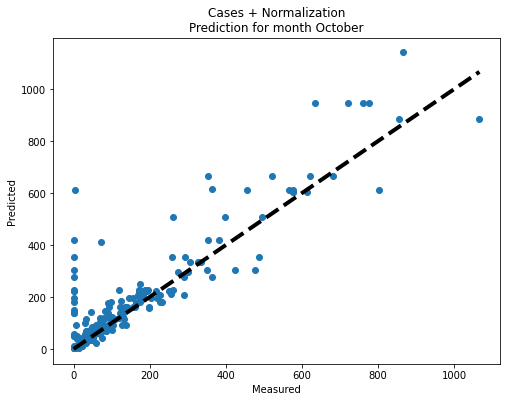

                 region   Predicted        Actual  Error
16         Baldwin Park  664.358636  3.540000e+02    310
41               Covina  418.820639  5.684342e-14    418
47             Downtown  946.496618  6.330000e+02    313
60   Florence-Firestone  610.014337  4.000000e+00    606
126            Pasadena  302.415894  5.684342e-14    302
158      South Whittier  355.226928  5.684342e-14    355
169     University Park  412.707309  7.300000e+01    339
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


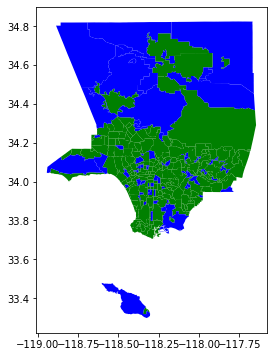

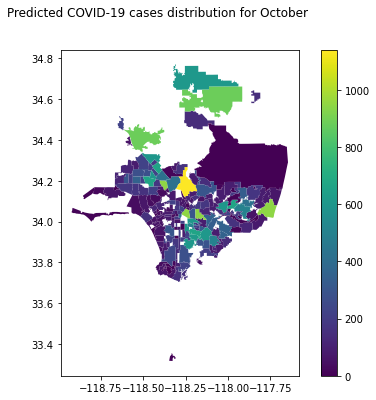

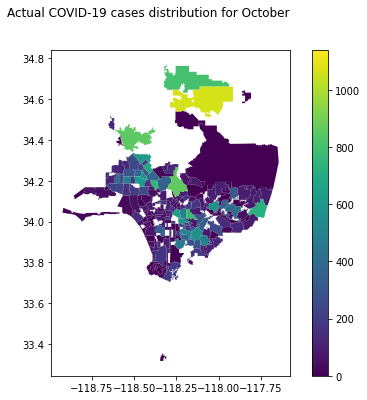

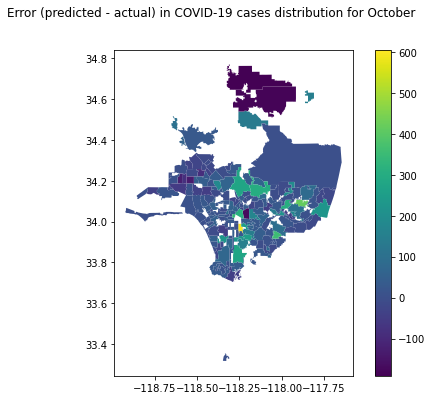

In [ ]:
month_data, used_regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization", nc5m_pty_arr, 5, used_regions)

### Add Migration

91
MSE: [6557.842389200729]; avg = 6557.842389200729 
r2: [0.8077929380042463]; avg = 0.8077929380042463
MAE: [49.13901273866214]; avg = 49.13901273866214
avg: [191.46153846153845]; avg = 191.46153846153845


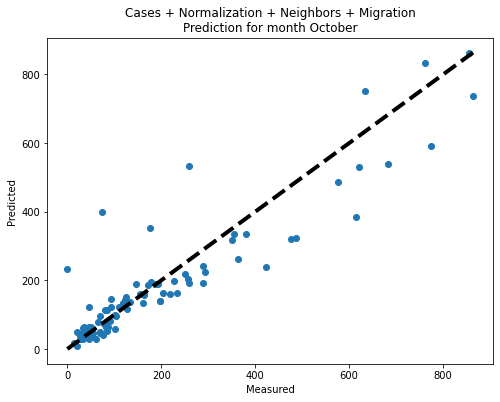

             region   Predicted  Actual  Error
75  University Park  400.175474    73.0    327
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


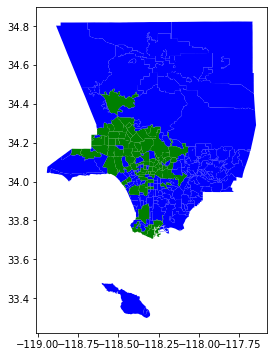

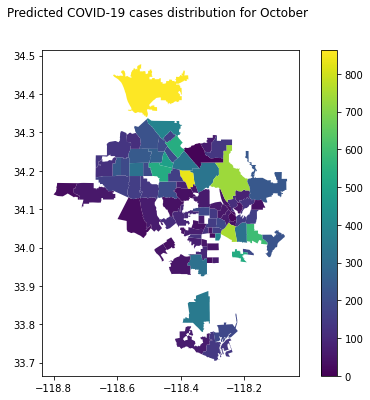

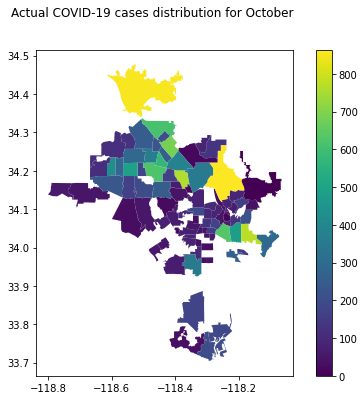

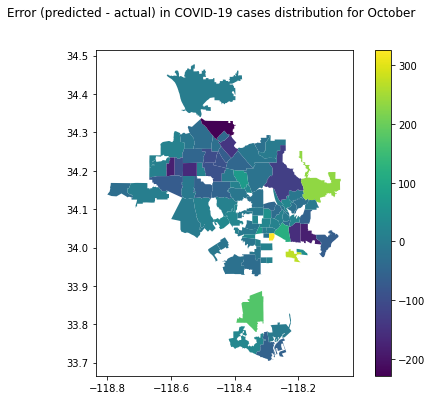

In [ ]:
month_data, used_regions = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5, used_regions)

### Add Census

91
MSE: [8861.324306204016]; avg = 8861.324306204016 
r2: [0.791170464796997]; avg = 0.791170464796997
MAE: [53.272993388189846]; avg = 53.272993388189846
avg: [191.46153846153845]; avg = 191.46153846153845


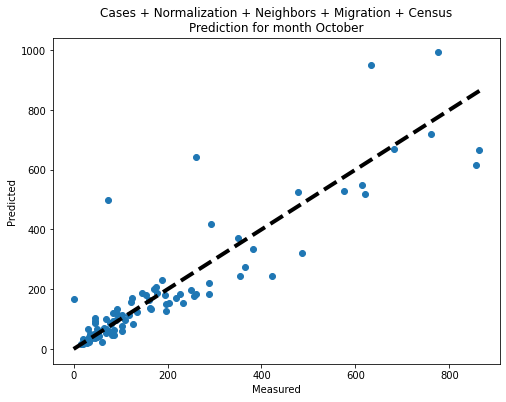

             region   Predicted  Actual  Error
16         Downtown  949.672688   633.0    316
33  Huntington Park  642.580159   260.0    382
75  University Park  499.956459    73.0    426
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


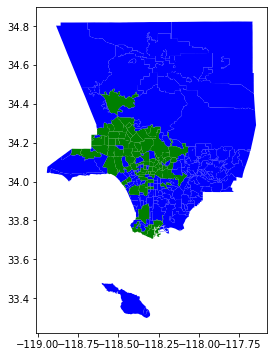

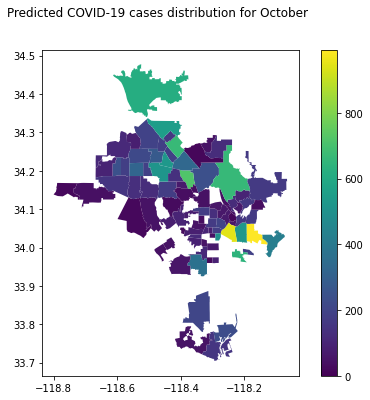

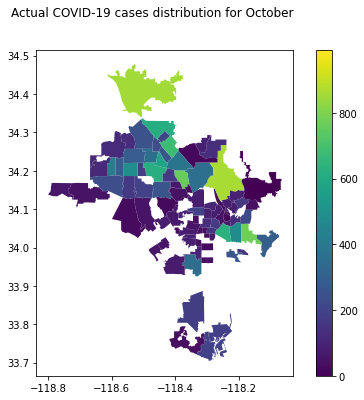

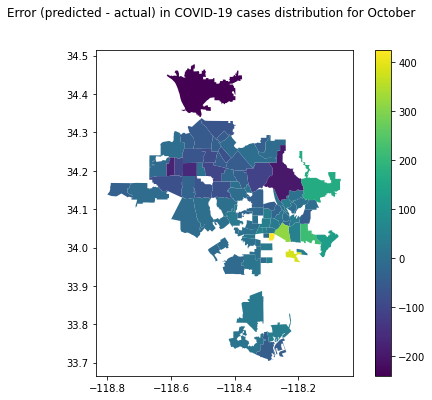

In [ ]:
month_data, used_regions = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5, used_regions)

### Feature Selection

In [ ]:
# month_data = build_month_data(False, True, True)
# nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
# lin_feat_subsets = f_selection(lin_model,nc5m_X_train_arr[0].shape[1],nc5m_X_train_arr[0],nc5m_y_train_arr[0])

In [ ]:
month_data, used_regions = build_month_data(False, True, True)
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ws, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection", nc5m_pty_arr, 5, used_regions)

91


NameError: ignored

In [ ]:
gb_param_grid = {
   'n_estimators': [100, 500, 1000],
    'max_depth': [2, 6, 10, 16],
    'min_samples_split': [2, 10, 50],
}

gb_model = GradientBoostingRegressor()
gb_search = GridSearchCV(gb_model, gb_param_grid)

In [ ]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_search, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection + Local Search", nc5m_pty_arr, 5)

In [ ]:
gb_search.best_estimator_

### Feature Importance

In [ ]:
feat_im_df = f_importances(gb_model, lin_feat_names, 'GBR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
month_data_ns = build_month_data(False, True)

In [ ]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

In [ ]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

In [ ]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_ns, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_ws, 2)

In [ ]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_ns, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_ws, 1)

In [ ]:
gb_param = {
    'max_depth': 2,
    'min_samples_split': 50,
}
gb_model = GradientBoostingRegressor(**gb_param)

## 5 month window

In [ ]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "GBR: 5-Month Window (no static)", nc5m_pty_arr, 5, used_regions)

In [ ]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, gb_model, "GBR: 5-Month Window (with static)", wc5m_pty_arr, 5, used_regions)

## 4 month window

In [ ]:
train_model(nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, gb_model, "GBR: 4-Month Window (no static)", nc4m_pty_arr, 4, used_regions)

In [ ]:
train_model(wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, gb_model, "GBR: 4-Month Window (with static)", wc4m_pty_arr, 4, used_regions)

## 3 month window

In [ ]:
train_model(nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, gb_model, "GBR: 3-Month Window (no static)", nc3m_pty_arr, 3, used_regions)

In [ ]:
train_model(wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, gb_model, "GBR: 3-Month Window (with static)", wc3m_pty_arr, 3, used_regions)

## 2 month window

In [ ]:
train_model(nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, gb_model, "GBR: 2-Month Window (no static)", nc2m_pty_arr, 2, used_regions)

In [ ]:
train_model(wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, gb_model, "GBR: 2-Month Window (with static)", wc2m_pty_arr, 2, used_regions)

## 1 month window

In [ ]:
train_model(nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, gb_model, "GBR: 1-Month Window (no static)", nc1m_pty_arr, 1, used_regions)

In [ ]:
train_model(wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, svr_model, "GBR: 1-Month Window (with static)", wc1m_pty_arr, 1, used_regions)

# Graph change in r^2

In [ ]:
y1=[0.794, 0.724, 0.434]
y2=[0.816, 0.7365, 0.737]
# plt.plot(x, y1, 'ro-', x, y2, 'bo-')
plt.plot(y1, 'bo-', label="No Static", )
plt.plot(y2, 'ro-', label="With Static")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks([0,1,2],[5,4,3])
plt.ylabel('r^2')
plt.xlabel('n-month window')
plt.title('SVR: change in r^2 across different time windows')
plt.figure(figsize=(7,7))
plt.show()

In [ ]:
y1=[0.792, 0.735, 0.419]
y2=[0.834, 0.708, 0.744]
# plt.plot(x, y1, 'ro-', x, y2, 'bo-')
plt.plot(y1, 'bo-', label="No Static", )
plt.plot(y2, 'ro-', label="With Static")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks([0,1,2],[5,4,3])
plt.ylabel('r^2')
plt.xlabel('n-month window')
plt.title('LinReg: change in r^2 across different time windows')
plt.figure(figsize=(7,7))
plt.show()

# XGBoost

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

# Feature Selection

## The following takes a long time to run!!! Just use the cell below this section

In [ ]:
month_data_with_census = build_month_data_with_census(census_data)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [ ]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)
xg_feat_subsets = f_selection(xg_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_y_train_arr[0])

In [ ]:
print(xg_feat_subsets)
np.save('../data/xg_feat_subsets.npy',xg_feat_subsets, allow_pickle=True)

## Run this section instead!!

In [ ]:
month_data_with_census = build_month_data_with_census(census_data)
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]
svr_feat_subsets

In [ ]:
def get_optimal_index(feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
    optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
    print(np.array(feature_names)[optimal_feat_index])
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    return optimal_index

In [ ]:
svr_optimal_index = get_optimal_index(svr_feat_subsets)
svr_optimal_index

## Generate train-test set

In [ ]:
# Select only the top features
temp = np.append(svr_optimal_index+1, month_data_with_census.shape[1]-1)
month_data_with_census = month_data_with_census[:, np.insert(temp, 0, 0, axis=0)] # Insert month and target columns
month_data_with_census.shape

In [ ]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [ ]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_no_census, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_with_census, 4)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_no_census, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_with_census, 3)

In [ ]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_no_census, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_with_census, 2)

In [ ]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_no_census, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_with_census, 1)

In [ ]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)

In [ ]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, xg_model, "XGB: 5-Month Window (no static)", 5)

In [ ]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, xg_model, "XGB: 5-Month Window (with static)", 5)

# Scratch Work

In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
        t1 = scale(power_transform(feat.reshape(-1,1)))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


In [ ]:
pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
#         t1 = scale(power_transform(feat.reshape(-1,1)))
        t1 = pipe.fit_transform(feat.reshape(-1,1))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.show()
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


In [ ]:
for i in range(wc4m_X_train_arr[0].shape[1]):
    s = skew(wc4m_X_train_arr[0][:,i])
    print("skewness: " + str(s))
    plt.hist(wc4m_X_train_arr[0][:,i])
    plt.title(feature_names[i-1])
    plt.show()
        


In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    plt.hist(month_data_with_census[:,i])
    plt.title(feature_names[i-1])
    plt.show()